# Differential gene expression over updated cell-types

In [1]:
# Load packages
suppressPackageStartupMessages({
    library(dplyr)
    library(data.table)
    library(ggplot2)
    library(SingleCellExperiment)
    library(scater)
    library(scran)
    library(edgeR)
    library(ggrastr)
})

here::i_am("differential/01_DEG_analysis_manual.ipynb")

# Load default settings
source(here::here("settings.R"))
source(here::here("utils.R"))

set.seed(1234)

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/01_Eomes_RNA/code



In [2]:
io$basedir

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/01_Eomes_RNA"

In [3]:
args = list()
args$sce = io$rna.sce
args$metadata = '/rds/project/rds-SDzz0CATGms/users/bt392/01_Eomes_RNA/results/rna/mapping/manual/metadata_mapping_updated.txt.gz'
args$variable = 'celltype_updated'
args$outdir = paste0(io$basedir,"/results/rna/differential/celltype_updated")
dir.create(args$outdir, recursive=TRUE, showWarnings = FALSE)

In [4]:
# Functions
# Plotting function
gg_volcano_plot <- function(celltype_i='Allantois', top_genes=20, xlim=5, ylim=40, label_groups = NULL) {
  to.plot = de.results[variable == celltype_i]
  negative_hits <- to.plot[sig==TRUE & logFC<0,gene]
  positive_hits <- to.plot[sig==TRUE & logFC>0,gene]
  all <- nrow(to.plot[!is.na(sig)])
  to.plot = to.plot[,logFC_plot:=ifelse(logFC<=-xlim, -xlim, ifelse(logFC>=xlim, xlim, logFC))] %>%
               .[,log10_padj_fdr:=ifelse(-log10(padj_fdr)>=ylim, ylim, -log10(padj_fdr))]
  
  to.plot <- to.plot[!is.na(logFC) & !is.na(padj_fdr)] %>% .[order(-abs(logFC))]
  label_genes = c(head(to.plot[sig==T & logFC<=0, gene],n=top_genes), head(to.plot[sig==T & logFC>=0, gene],n=top_genes))
  
  p <- ggplot(to.plot, aes(x=logFC_plot, y=log10_padj_fdr)) +
    labs(x="Log fold change", y=expression(paste("-log"[10],"(q.value)"))) +
    ggrastr::geom_point_rast(aes(color=sig, size=sig)) +
    # geom_hline(yintercept = -log10(opts$threshold_fdr), color="blue") +
    geom_segment(aes(x=0, xend=0, y=0, yend=ylim*1.05), color="orange", size=0.5) +
    scale_color_manual(values=c("black","red")) +
    scale_size_manual(values=c(0.5,1)) +
    scale_x_continuous(limits=c(-xlim,xlim)) +
    scale_y_continuous(limits=c(0,ylim*1.16)) +
    annotate("text", x=0, y=ylim*1.1, size=6, label=sprintf("(%d)", all)) +
    annotate("text", x=-xlim*0.9, y=ylim*1.15, size=6, label=sprintf("%d (-)",length(negative_hits))) +
    annotate("text", x=xlim*0.9, y=ylim*1.15, size=6, label=sprintf("%d (+)",length(positive_hits))) +
    ggrepel::geom_text_repel(data=to.plot[gene %in% label_genes],
                                    aes(x=logFC_plot, y=log10_padj_fdr, label=gene), 
                                     max.overlaps=Inf, 
                                     box.padding = 0.5,
                                     bg.color='white', 
                                     bg.r = 0.1,
                                     size=5) +
    theme_classic() +
    theme(
       axis.text = element_text(color='black'),
      # axis.title = element_text(size=rel(1.0), color='black'),
      text=element_text(size=15),
      legend.position="none"
    ) + 
    ggtitle(celltype_i)
    
    
  if (length(label_groups)>0) {
    p <- p +
      annotate("text", x=-4, y=0, size=4, label=sprintf("Up in %s",label_groups[2])) +
      annotate("text", x=4, y=0, size=4, label=sprintf("Up in %s",label_groups[1]))
  }
  
  return(p)
}

In [5]:
###############
## Load data ##
###############

# Load metadata
sample_metadata <- fread(args$metadata) %>%
   .[,pool:=stringr::str_replace_all(sample,opts$sample2pool)] %>% 
   .[,variable := .[[args$variable]]]

# Load RNA expression data as SingleCellExperiment object
sce <- load_SingleCellExperiment(args$sce, cells=sample_metadata$cell, normalise = TRUE)

# Add sample metadata as colData
colData(sce) <- sample_metadata %>% tibble::column_to_rownames("cell") %>% DataFrame

In [6]:
nrow(sample_metadata)

[1] 28723

In [50]:
# Pseudobulk by sample and variable
summed <- aggregateAcrossCells(sce, 
    id=colData(sce)[,c("variable", "sample", "tdTom")])

summed.filt <- summed[,summed$ncells >= 20]

In [8]:
# specific genes
# Genes are tested to be significantly different from the average LFC of all cell-types
de.results <- pseudoBulkSpecific(summed.filt, 
    label=summed.filt$variable,
    design=~factor(pool) + tdTom,
    coef="tdTomTRUE",
    condition=summed.filt$tdTom,
    average = 'median'
    ) %>% unlist() %>% 
        as.data.table(keep.rownames=T) %>%
        .[,`:=`(gene=str_split(rn, '\\.') %>% map_chr(2), # extract gene names
                variable=str_split(rn, '\\.') %>% map_chr(1), # extract cell type
                rn=NULL, 
                sig=ifelse(abs(logFC)>=0.5 & FDR<=0.05, TRUE, FALSE))] %>%  # significance
        .[!is.na(logFC),] %>%
        setnames('FDR', 'padj_fdr')

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


In [9]:
fwrite(de.results, file.path(args$outdir, 'pseudoBulkSpecific.txt.gz'))

In [7]:
de.results = fread(file.path(args$outdir, 'pseudoBulkSpecific.txt.gz'))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


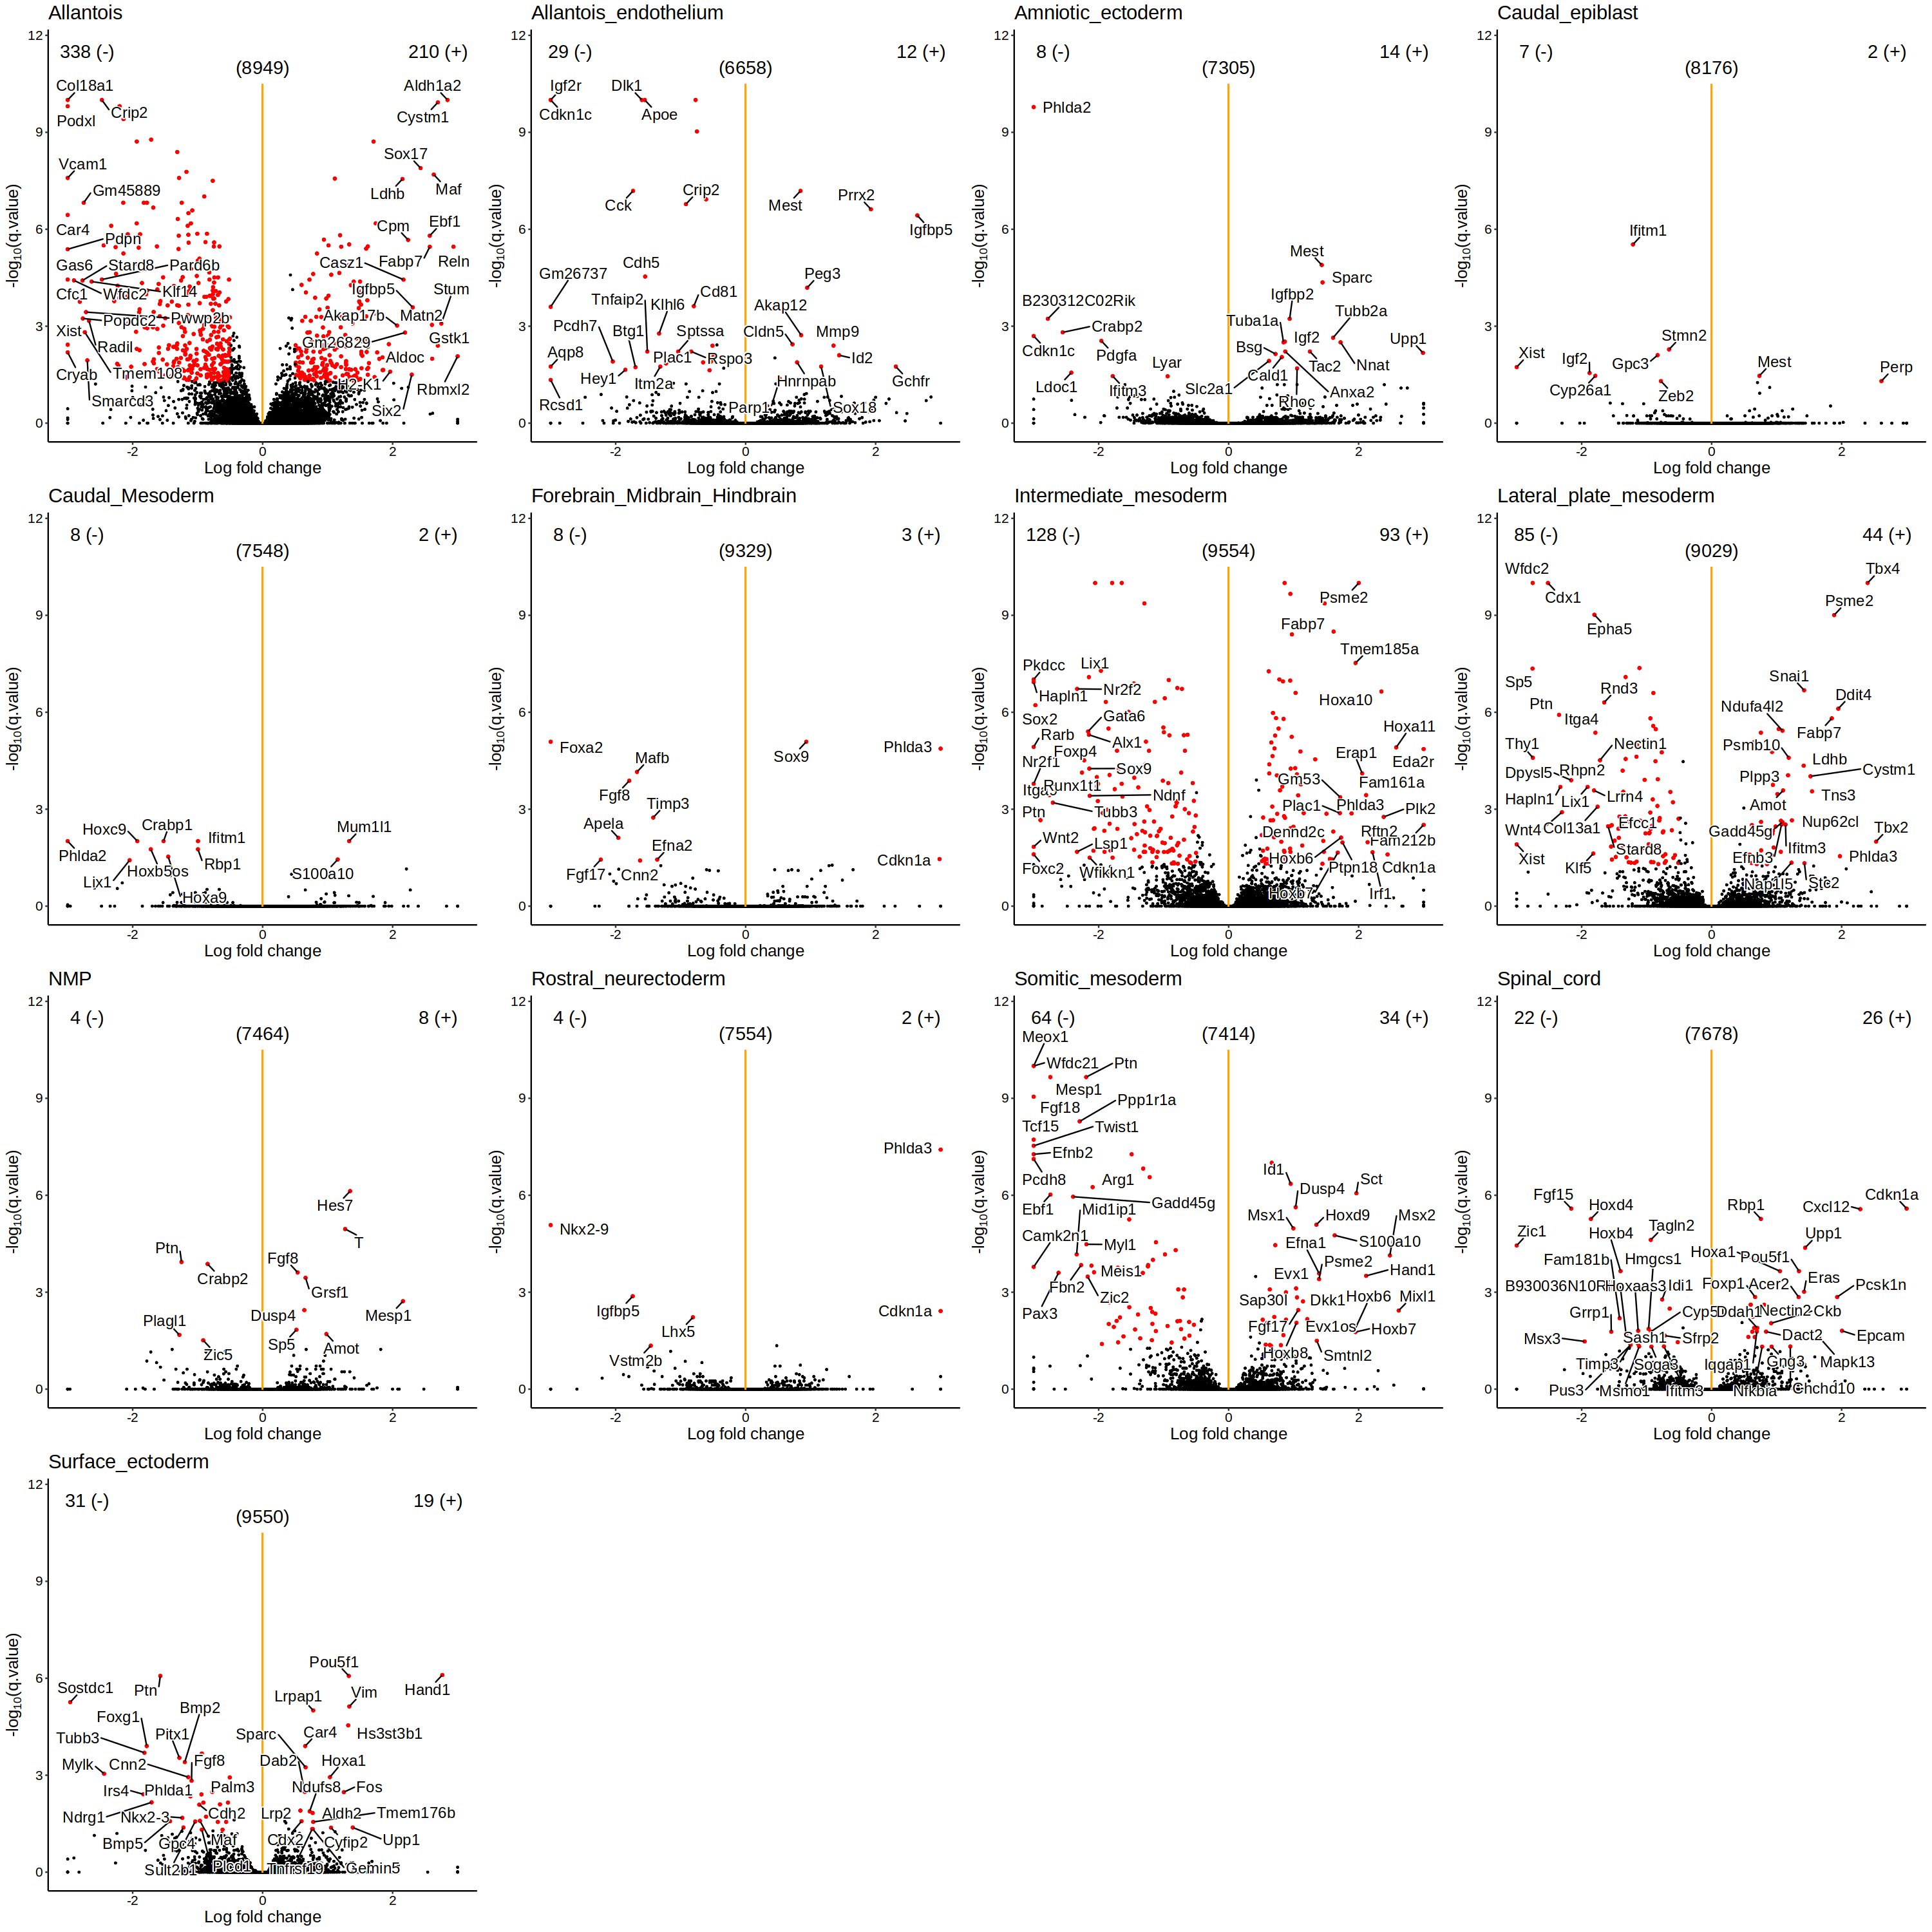

In [8]:
# Make plots
plots = lapply(unique(de.results$variable),gg_volcano_plot, ylim=10, xlim=3)
combined_plot <- cowplot::plot_grid(plotlist = plots, ncol = 4)
options(repr.plot.width=25, repr.plot.height=25)
combined_plot

In [9]:
head(de.results)

logFC      logCPM   F           PValue       padj_fdr     OtherAverage
1  2.4300800 4.693565 118.3691169 1.717675e-11 1.280956e-08 -0.38042566 
2  0.1141347 7.647249   1.4512978 8.572185e-01 1.000000e+00  0.09694575 
3  0.1685335 4.624626   0.8422278 7.643426e-01 1.000000e+00  0.11301293 
4 -0.1891444 7.271503   3.4604979 2.925666e-01 7.569176e-01 -0.08013203 
5  0.1165797 5.195631   0.5648115 1.000000e+00 1.000000e+00  0.18470133 
6  0.2197346 6.039628   1.8795368 1.855267e-01 6.032989e-01 -0.08676637 
  gene    variable  sig  
1 Sox17   Allantois  TRUE
2 Mrpl15  Allantois FALSE
3 Lypla1  Allantois FALSE
4 Tcea1   Allantois FALSE
5 Atp6v1h Allantois FALSE
6 Rb1cc1  Allantois FALSE

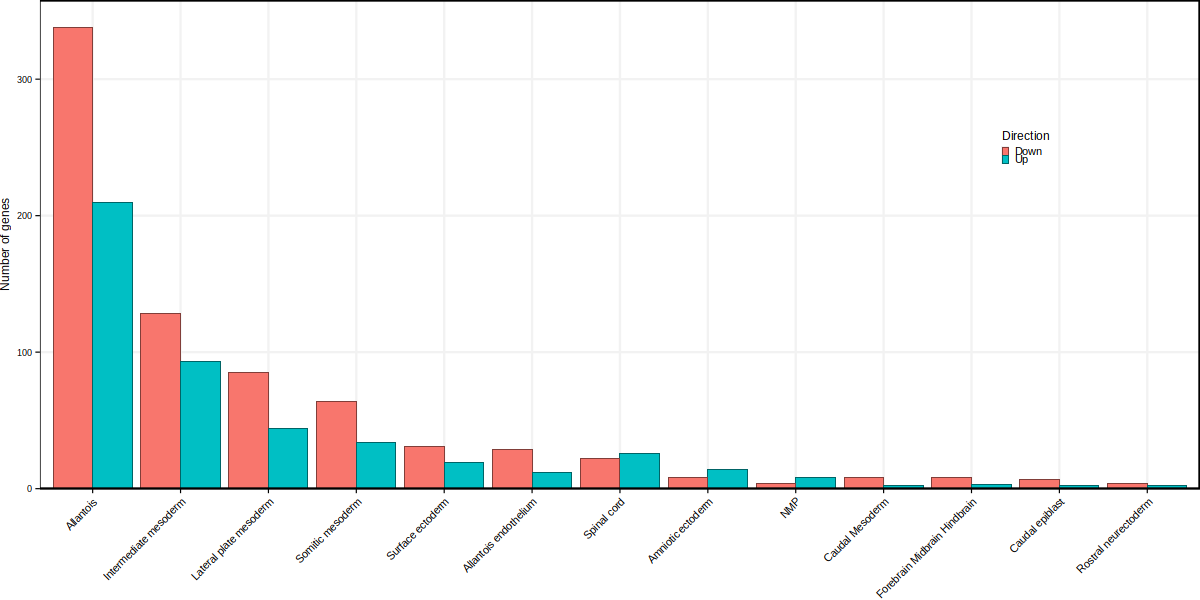

In [114]:
DEG_numbers = rbind(de.results[logFC>0 & sig == T][,N := .N, by = c('variable')] %>% unique(by = c('variable')) %>% .[,Direction := 'Up'],
                   de.results[logFC<0 & sig == T][,N := .N, by = c('variable')] %>% unique(by = c('variable')) %>% .[,Direction := 'Down']) %>% 
    .[order(-N)] %>% 
    .[,variable := gsub('_', ' ', variable)] %>% 
    .[,variable := factor(variable, levels = unique(variable))]


options(repr.plot.width=10, repr.plot.height=5)
p1 = ggplot(DEG_numbers, aes(variable, N, fill = Direction)) + 
    geom_bar(stat = 'identity', position = 'dodge', color = 'black', size = 0.1) + 
    scale_y_continuous(expand = c(0,0,0, 20)) + 
    guides(fill = guide_legend(override.aes = list(size = 0.1))) + 
    ylab('Number of genes') +
    theme(
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 7),
        axis.text.x = element_text(angle=45, hjust=1, vjust=1, size=6, color = 'black'), 
        axis.text = element_text(size=5, color='black'),
        text = element_text(size=6),
        plot.margin = margin(0, 0, 0, 0),  # Adjust the margin around the plot
        plot.title = element_text(size=7, face='plain', hjust=0.5, vjust = -0.5),
        panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
        panel.background = element_blank(),
        panel.grid.major = element_line(color = 'grey95'),
        axis.line = element_blank(),
        axis.ticks = element_line(linewidth=0.25, color = 'black'),
        legend.position = c(0.85, 0.7),
        legend.title = element_text(size = 7),
        legend.text = element_text(size = 6),
        legend.key.size = unit(1.5, "mm"),
        legend.margin = margin(0,0,0,0)
    )

p1 

ggsave(file.path(io$basedir, 'figures/Eomes_chimera_DEG_numbers.pdf'), 
       plot = p1,
       width = 60, 
       height = 40, 
       units = "mm")

In [111]:
# Functions
# Plotting function
gg_volcano_plot <- function(celltype_i='Allantois', top_genes=20, xlim=5, ylim=40, label_groups = NULL, y_axis = T) {
  to.plot = de.results[variable == celltype_i]
  negative_hits <- to.plot[sig==TRUE & logFC<0,gene]
  positive_hits <- to.plot[sig==TRUE & logFC>0,gene]
  all <- nrow(to.plot[!is.na(sig)])
  to.plot = to.plot[,logFC_plot:=ifelse(logFC<=-xlim, -xlim, ifelse(logFC>=xlim, xlim, logFC))] %>%
               .[,log10_padj_fdr:=ifelse(-log10(padj_fdr)>=ylim, ylim, -log10(padj_fdr))]
  
  to.plot <- to.plot[!is.na(logFC) & !is.na(padj_fdr)] %>% .[order(-abs(logFC))]
  to.plot <- to.plot[!is.na(logFC) & !is.na(padj_fdr)] %>% .[order(padj_fdr)]
  label_genes = c(head(to.plot[sig==T & logFC<=0, gene],n=top_genes), head(to.plot[sig==T & logFC>=0, gene],n=top_genes))
  
  p <- ggplot(to.plot, aes(x=logFC_plot, y=log10_padj_fdr)) +
    labs(x="Log fold change", y=expression(paste("-log"[10],"(FDR)"))) +
    ggrastr::rasterize(geom_point(aes(color=sig, size=sig), size = -0.3), dpi = 900) +
    # geom_hline(yintercept = -log10(opts$threshold_fdr), color="blue") +
    geom_segment(aes(x=0, xend=0, y=0, yend=ylim*1.16), color="orange", size=0.1) +
    scale_color_manual(values=c("black","red")) +
    scale_size_manual(values=c(0.5,1)) +
    scale_x_continuous(limits=c(-xlim,xlim)) +
    scale_y_continuous(limits=c(0,ylim*1.2), expand = c(0,0,0, 0)) +

    # annotate("text", x=0, y=ylim*1.1, size=6*0.35, label=sprintf("(%d)", all)) +
    annotate("text", x=-xlim*0.9, y=ylim*1.15, size=6*0.35, label=sprintf("%d (-)",length(negative_hits))) +
    annotate("text", x=xlim*0.9, y=ylim*1.15, size=6*0.35, label=sprintf("%d (+)",length(positive_hits))) +
    ggrepel::geom_text_repel(data=to.plot[gene %in% label_genes],
                                    aes(x=logFC_plot, y=log10_padj_fdr, label=gene), 
                                     max.overlaps=Inf, 
                                     box.padding = 0.1,
                                     segment.size = unit(0.1, 'mm'),
                                     bg.color='white', 
                                     bg.r = 0.1,
                                     size=6*0.35) +
    theme_classic() +
    theme(
      # axis.title = element_text(size=rel(1.0), color='black'),
      legend.position="none",
                panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
        plot.title = element_text(size = 8, hjust = 0.5, face = 'plain'),
                axis.line = element_blank(),
        axis.ticks = element_line(linewidth=0.25, color = 'black'),
        axis.title.x = element_text(size = 7),
        axis.title.y = element_text(size = 7),
        # axis.text.x = element_text(angle=45, hjust=1, vjust=1, size=6, color = 'black'),
        plot.margin = margin(0,4,0,0),
        axis.text = element_text(size=6, color='black'),
        text = element_text(size=6),

    ) + 
    ggtitle(gsub('_', ' ', celltype_i))
    
    if(y_axis == F){
        p = p + theme(axis.text.y = element_blank(),
                      axis.title.y = element_blank())
    }
    
    
    if (length(label_groups)>0) {
        p <- p +
            annotate("text", x=-4, y=0, size=4, label=sprintf("Up in %s",label_groups[2])) +
            annotate("text", x=4, y=0, size=4, label=sprintf("Up in %s",label_groups[1]))
    }
  
  return(p)
}



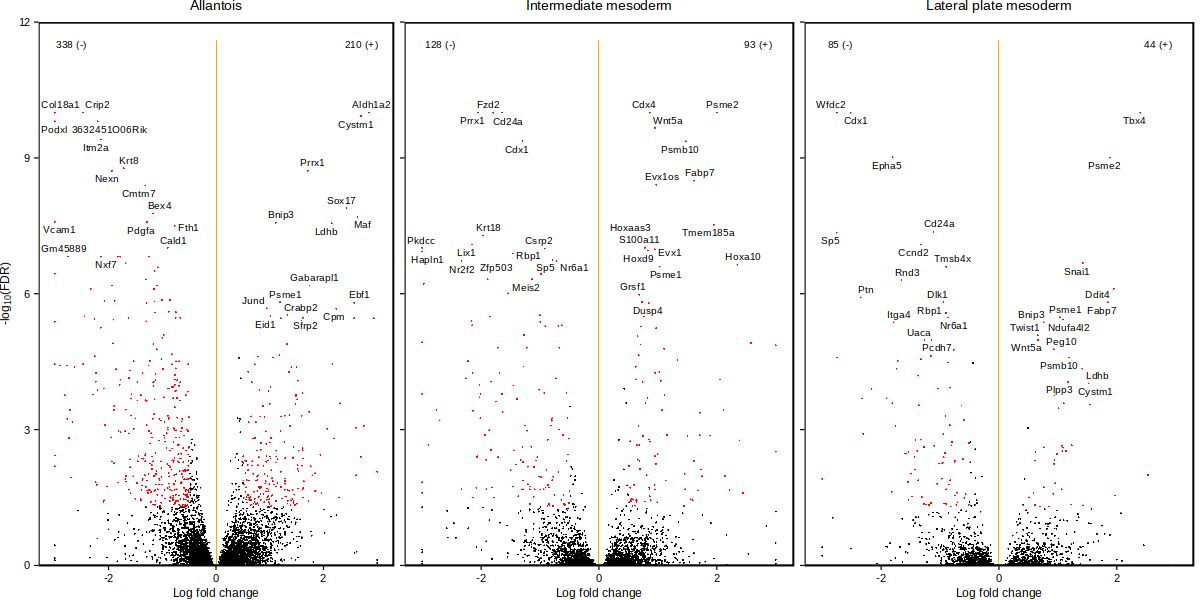

In [112]:

p_allantois = gg_volcano_plot(celltype_i='Allantois', ylim=10, xlim=3, top_genes = 15)
p_interm = gg_volcano_plot(celltype_i='Intermediate_mesoderm', ylim=10, xlim=3, top_genes = 15, y_axis = F)
p_lpm = gg_volcano_plot(celltype_i='Lateral_plate_mesoderm', ylim=10, xlim=3, top_genes = 15, y_axis = F)

ggarrange(p_allantois, p_interm, p_lpm, nrow = 1)

In [113]:
ggsave(file.path(io$basedir, 'figures/Eomes_chimera_volcanos.pdf'), 
       plot = ggarrange(p_allantois, p_interm, p_lpm, nrow = 1),
       width = 185, 
       height = 60, 
       units = "mm")

In [11]:
GeomSplitViolin <- ggproto("GeomSplitViolin", GeomViolin, 
                           draw_group = function(self, data, ..., draw_quantiles = NULL) {
  data <- transform(data, xminv = x - violinwidth * (x - xmin), xmaxv = x + violinwidth * (xmax - x))
  grp <- data[1, "group"]
  newdata <- plyr::arrange(transform(data, x = if (grp %% 2 == 1) xminv else xmaxv), if (grp %% 2 == 1) y else -y)
  newdata <- rbind(newdata[1, ], newdata, newdata[nrow(newdata), ], newdata[1, ])
  newdata[c(1, nrow(newdata) - 1, nrow(newdata)), "x"] <- round(newdata[1, "x"])

  if (length(draw_quantiles) > 0 & !scales::zero_range(range(data$y))) {
    stopifnot(all(draw_quantiles >= 0), all(draw_quantiles <=
      1))
    quantiles <- ggplot2:::create_quantile_segment_frame(data, draw_quantiles)
    aesthetics <- data[rep(1, nrow(quantiles)), setdiff(names(data), c("x", "y")), drop = FALSE]
    aesthetics$alpha <- rep(1, nrow(quantiles))
    both <- cbind(quantiles, aesthetics)
    quantile_grob <- GeomPath$draw_panel(both, ...)
    ggplot2:::ggname("geom_split_violin", grid::grobTree(GeomPolygon$draw_panel(newdata, ...), quantile_grob))
  }
  else {
    ggplot2:::ggname("geom_split_violin", GeomPolygon$draw_panel(newdata, ...))
  }
})

geom_split_violin <- function(mapping = NULL, data = NULL, stat = "ydensity", position = "identity", ..., 
                              draw_quantiles = NULL, trim = TRUE, scale = "area", na.rm = FALSE, 
                              show.legend = NA, inherit.aes = TRUE) {
  layer(data = data, mapping = mapping, stat = stat, geom = GeomSplitViolin, 
        position = position, show.legend = show.legend, inherit.aes = inherit.aes, 
        params = list(trim = trim, scale = scale, draw_quantiles = draw_quantiles, na.rm = na.rm, ...))
}

In [21]:
quantile_cutoff = 0.9995
celltypes = unique(de.results$variable)
gene_list = unique(de.results %>% .[sig==TRUE] %>% .[variable %in% celltypes] %>% 
               # .[order(-abs(logFC))] %>% 
                 .[order(padj_fdr)] %>% 
                .[abs(logFC)< 1] %>% 
                .[,head(.SD, 10), by=variable] %>% .$gene)
test = mclapply(gene_list, function(x){
    tmp = sample_metadata %>% copy() %>%
        .[,gene:=as.vector(logcounts(sce[x,]))] %>% .[,gene_name :=x] %>%
        .[,gene_quantcutoff:=ifelse(gene > quantile(gene, quantile_cutoff), quantile(gene, quantile_cutoff), gene)]
    return(tmp)
}, mc.cores=16) %>% rbindlist() %>% 
    .[,variable := ifelse(variable %in% celltypes, variable, 'Other'),]


In [18]:
quantile_cutoff = 0.9995
celltypes = c('Caudal_neurectoderm','Forebrain_Midbrain_Hindbrain', 'Rostral_neurectoderm', 'Spinal_cord', 'NMP', 'Surface_ectoderm', 'Amniotic_ectoderm')
gene_list = unique(de.results %>% .[sig==TRUE] %>% .[variable %in% celltypes] %>% 
                .[order(-abs(logFC))] %>% 
                # .[order(padj_fdr)] %>% 
                .[,head(.SD, 50), by=variable] %>% .$gene)
test = mclapply(gene_list, function(x){
    tmp = sample_metadata %>% copy() %>%
        .[,gene:=as.vector(logcounts(sce[x,]))] %>% .[,gene_name :=x] %>%
        .[,gene_quantcutoff:=ifelse(gene > quantile(gene, quantile_cutoff), quantile(gene, quantile_cutoff), gene)]
    return(tmp)
}, mc.cores=16) %>% rbindlist() %>% 
    .[,variable := ifelse(variable %in% celltypes, variable, 'Other'),]


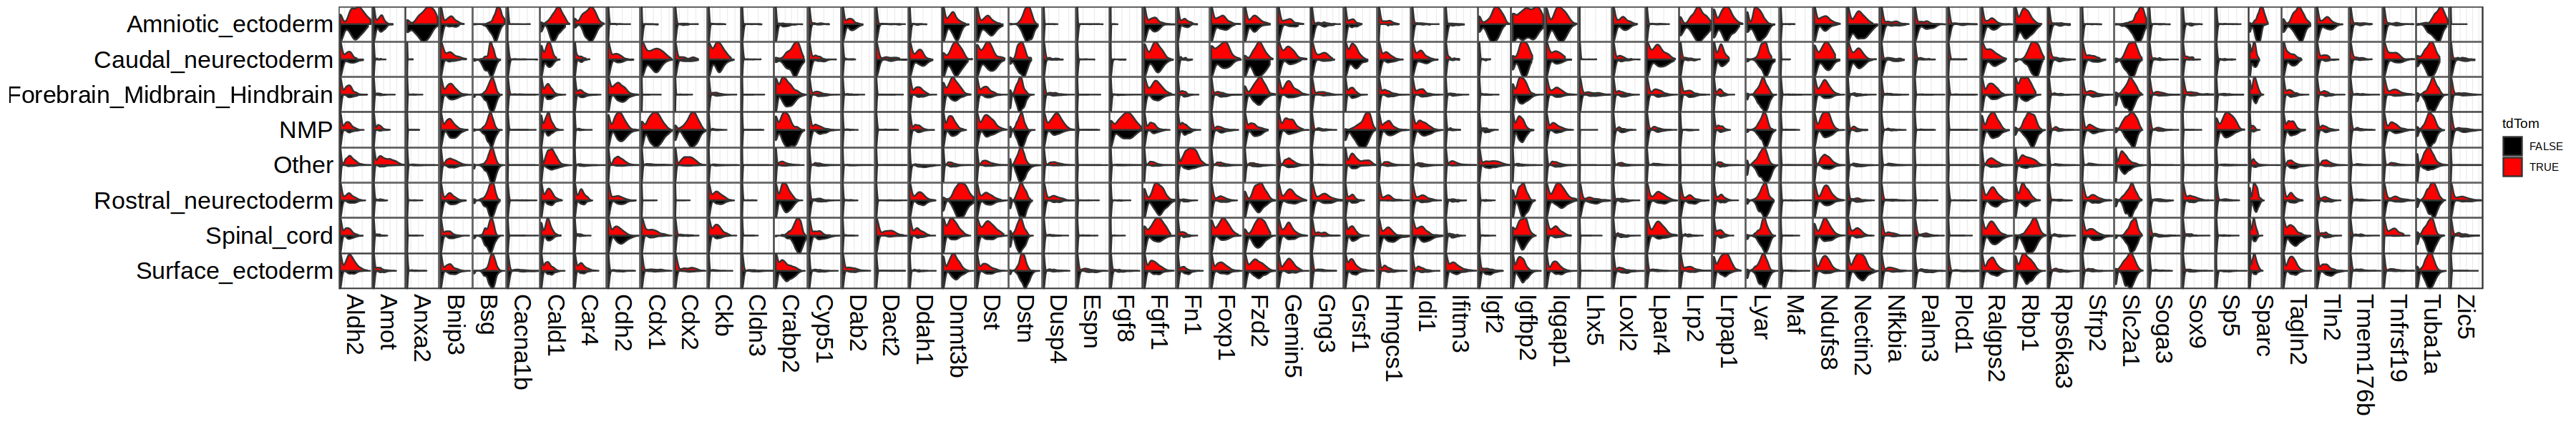

In [20]:
options(repr.plot.width=30, repr.plot.height=5)
#test$gene = test$gene + rnorm(n = nrow(test))/10 # Seurat adds noise to make violins look better??
suppressWarnings({ggplot(test, aes('x', gene_quantcutoff, fill=tdTom)) + 
    geom_split_violin(scale='width') + 
 #  geom_violin(trim=TRUE, scale = "width") +
    coord_flip() + 
    scale_x_discrete(expand = c(0, 0)) +
    facet_grid(rows = vars(variable), cols=vars(gene_name), switch="both", scales='free_x') + 
    scale_fill_manual(values=c('TRUE'='red', 'FALSE' = 'black')) + 
    theme_bw() + 
    theme(axis.text=element_blank(),
          axis.ticks = element_blank(),
          axis.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.border = element_rect(),
          strip.background = element_blank(),
          strip.text.x = element_text(angle=-90, hjust=0, vjust=0.5, color='black', size=20),
          strip.text.y.left = element_text(angle=0, hjust=1, vjust=0.5, color='black', size=20),
         panel.spacing=unit(0, "lines"))
})

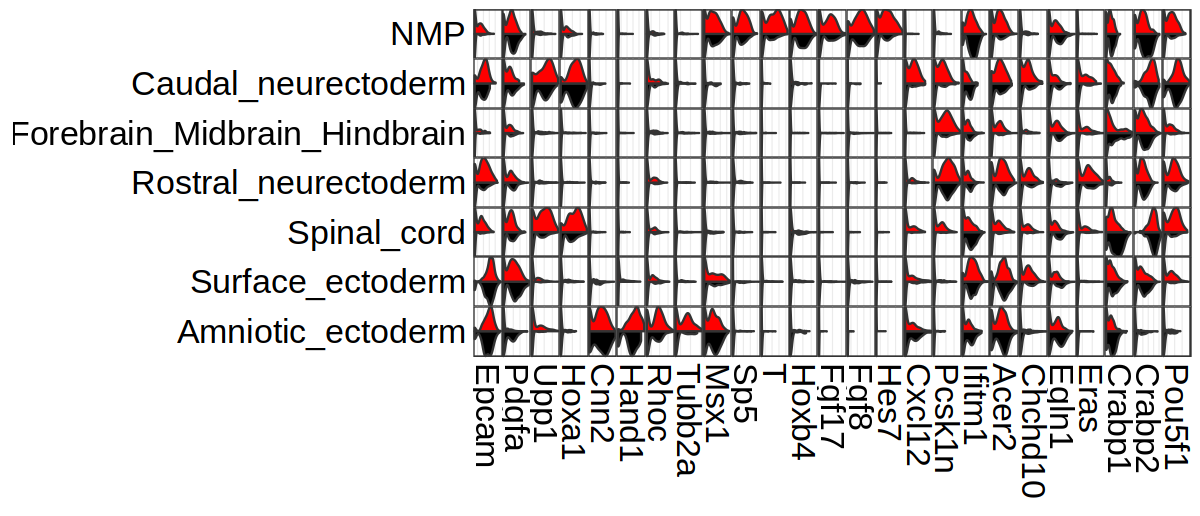

In [14]:
celltypes = c('NMP', 'Caudal_neurectoderm','Forebrain_Midbrain_Hindbrain', 'Rostral_neurectoderm', 'Spinal_cord', 'Surface_ectoderm', 'Amniotic_ectoderm')
gene_list = unique(c('Epcam', 'Pdgfa', 'Upp1', 'Hoxa1', 
                    'Cnn2', 'Hand1',  'Rhoc', 'Tubb2a', # Amniotic ectoderm
                     'Msx1', 'Sp5', 'T','Hoxb4', 'Fgf17', 'Fgf8', 'Hes7', 'Cxcl12',
             'Pcsk1n',  'Ifitm1', 'Iftm3', 'Upp1','Acer2', 'Chchd10', 'Egln1', 'Eras',
              'Pdgfa', 'Crabp1', 'Crabp2', 'Pou5f1'))
             
gene_list = gene_list[gene_list %in% rownames(sce)]
test = mclapply(gene_list, function(x){
    tmp = sample_metadata %>% copy() %>%
        .[,gene:=as.vector(logcounts(sce[x,]))] %>% .[,gene_name :=x] %>%
        .[,gene_quantcutoff:=ifelse(gene > quantile(gene, quantile_cutoff), quantile(gene, quantile_cutoff), gene)]
    return(tmp)
}, mc.cores=16) %>% rbindlist() %>% 
    .[,variable := ifelse(variable %in% celltypes, variable, 'Other'),] %>% 
    .[,variable := factor(variable, levels = c(celltypes, 'Other'))] %>% 
    .[,gene_name := factor(gene_name, levels = gene_list)] %>% 
    .[variable != 'Other']


options(repr.plot.width=10, repr.plot.height=4.3)
#test$gene = test$gene + rnorm(n = nrow(test))/10 # Seurat adds noise to make violins look better??
suppressWarnings({ggplot(test, aes('x', gene_quantcutoff, fill=tdTom)) + 
    geom_split_violin(scale='width') + 
 #  geom_violin(trim=TRUE, scale = "width") +
    coord_flip() + 
    scale_x_discrete(expand = c(0, 0)) +
    facet_grid(rows = vars(variable), cols=vars(gene_name), switch="both", scales='free_x') + 
    scale_fill_manual(values=c('TRUE'='red', 'FALSE' = 'black')) + 
    theme_bw() + 
    theme(axis.text=element_blank(),
          axis.ticks = element_blank(),
          axis.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.border = element_rect(),
          strip.background = element_blank(),
          strip.text.x = element_text(angle=-90, hjust=0, vjust=0.5, color='black', size=20),
          strip.text.y.left = element_text(angle=0, hjust=1, vjust=0.5, color='black', size=20),
          legend.position='none',
         panel.spacing=unit(0, "lines"))
}) 

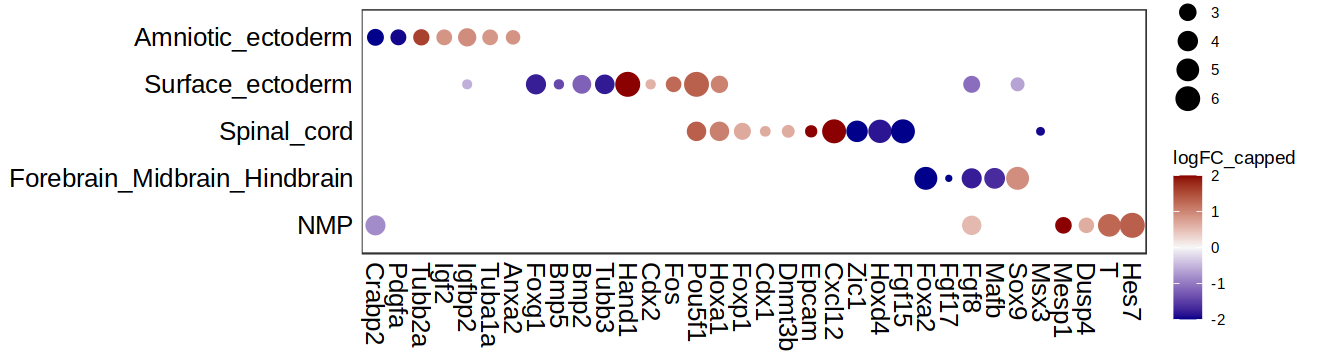

In [89]:
celltypes = c('NMP', 'Caudal_neurectoderm','Forebrain_Midbrain_Hindbrain', 'Spinal_cord', 'Surface_ectoderm', 'Amniotic_ectoderm') # 'Rostral_neurectoderm', 

gene_list = unique(c('Crabp2', 'Pdgfa', 'Tubb2a' , 'Igf2','Igfbp2', 'Tuba1a', 'Anxa2', 
     'Foxg1', 'Bmp5', 'Bmp2', 'Tubb3','Hand1', 'Cdx2', 'Fos','Pou5f1', 'Hoxa1', 
    'Foxp1', 'Cdx1', 'Dnmt3b', 'Epcam', 'Cxcl12','Zic1', 'Hoxb1', 'Hoxd4', 'Fgf15', 
    'Foxa2', 'Fgf17', 'Fgf8', 'Mafb', 'Sox9',
    'Msx3', 'Mesp1', 'Dusp4', 'T', 'Hes7'
                    ))


to.plot = de.results %>% copy() %>% 
    .[variable %in% celltypes & gene %in% gene_list] %>% 
    .[, gene := factor(gene, levels = gene_list)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                             ifelse(logFC <= -2, -2, logFC))] %>%
    .[,variable := factor(variable, levels = celltypes)]

options(repr.plot.width=11, repr.plot.height=3)
#
ggplot(to.plot[sig==T], aes(gene, variable, color = logFC_capped, size = -log10(padj_fdr))) + 
    geom_point() + 
    scale_color_gradient2(low = 'darkblue', mid = 'grey97', high = 'darkred') +
    theme_bw() + 
    theme(#axis.text=element_blank(),
          axis.ticks = element_blank(),
          axis.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.border = element_rect(),
          axis.text = element_text(size = 15, color = 'black'),
          axis.text.x = element_text(angle = -90, hjust = 0, vjust = 0.5)
    )

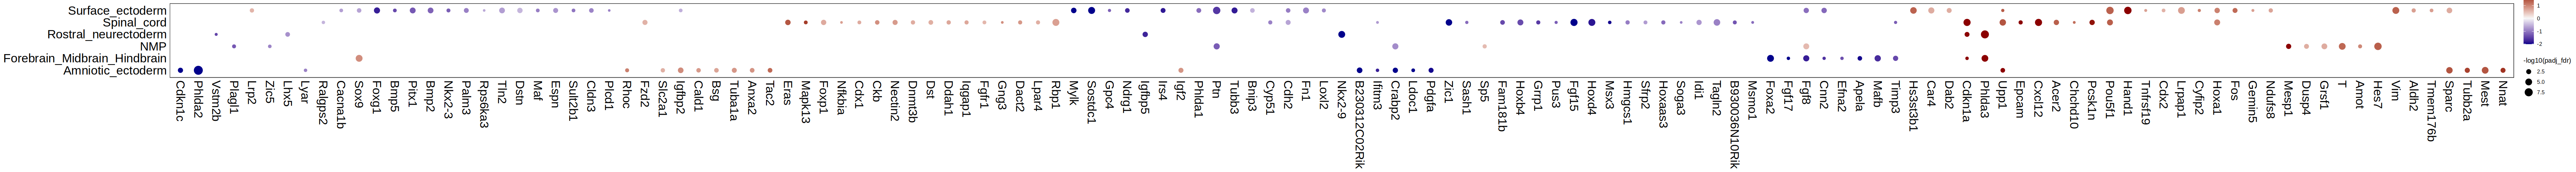

In [69]:
celltypes = c('NMP', 'Caudal_neurectoderm','Forebrain_Midbrain_Hindbrain', 'Rostral_neurectoderm', 'Spinal_cord', 'Surface_ectoderm', 'Amniotic_ectoderm')
gene_list = unique(de.results %>% .[sig==TRUE] %>% .[variable %in% celltypes] %>% 
                .[order(-abs(logFC))] %>% 
                 .[order(padj_fdr)] %>% 
                .[,head(.SD, 60), by=variable] %>% .$gene)

# Turn dt in matrix
DEGs.mtx = de.results[gene %in% gene_list & variable %in% celltypes ,c('gene',  'logFC', 'variable')] %>% dcast(., variable ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('variable')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

to.plot = de.results %>% copy() %>% 
    .[variable %in% celltypes & gene %in% gene_list] %>% 
    .[, gene := factor(gene, levels = gene_list)] %>% 
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                             ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=60, repr.plot.height=4)
ggplot(to.plot[sig==T], aes(gene, variable, color = logFC_capped, size = -log10(padj_fdr))) + 
    geom_point() + 
    scale_color_gradient2(low = 'darkblue', mid = 'grey97', high = 'darkred') +
    theme_bw() + 
    theme(#axis.text=element_blank(),
          axis.ticks = element_blank(),
          axis.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.border = element_rect(),
          axis.text = element_text(size = 20, color = 'black'),
          axis.text.x = element_text(angle = -90, hjust = 0, vjust = 0.5)
    )

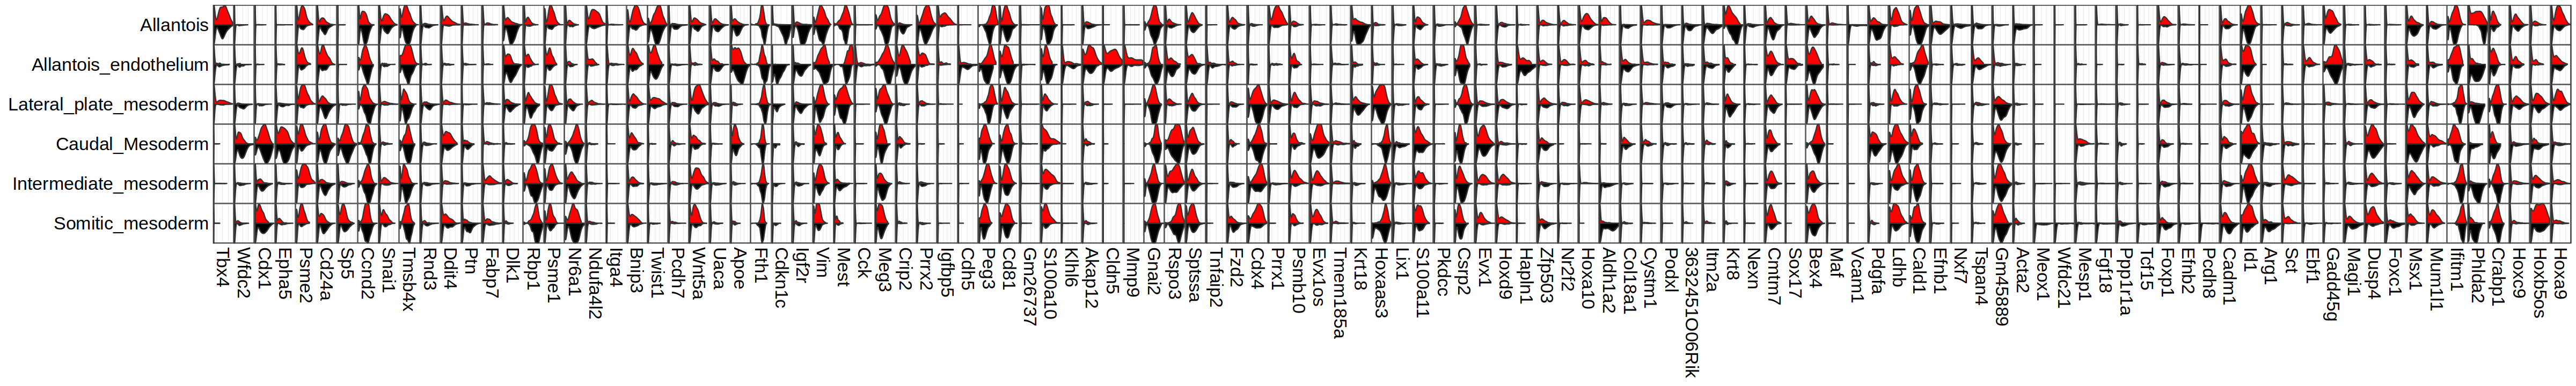

In [15]:
# plot genes that are significant in at least one of the cell types
quantile_cutoff = 0.9995
celltypes = c('Allantois','Allantois_endothelium','Lateral_plate_mesoderm','Caudal_Mesoderm', 'Intermediate_mesoderm', 'Somitic_mesoderm')
gene_list = unique(de.results %>% .[sig==TRUE] %>% .[variable %in% celltypes] %>% 
               # .[order(-abs(logFC))] %>% 
                .[order(padj_fdr)] %>% 
                .[,head(.SD, 25), by=variable] %>% .$gene)
test = mclapply(gene_list, function(x){
    tmp = sample_metadata %>% copy() %>%
        .[,gene:=as.vector(logcounts(sce[x,]))] %>% .[,gene_name :=x] %>%
        .[,gene_quantcutoff:=ifelse(gene > quantile(gene, quantile_cutoff), quantile(gene, quantile_cutoff), gene)]
    return(tmp)
}, mc.cores=16) %>% rbindlist() %>% 
    .[,variable := ifelse(variable %in% celltypes, variable, 'Other'),] %>% 
    .[,variable := factor(variable, levels = c(celltypes, 'Other'))] %>% 
    .[,gene_name := factor(gene_name, levels = gene_list)] %>% 
    .[variable != 'Other']

options(repr.plot.width=40, repr.plot.height=6)
#test$gene = test$gene + rnorm(n = nrow(test))/10 # Seurat adds noise to make violins look better??
suppressWarnings({ggplot(test, aes('x', gene_quantcutoff, fill=tdTom)) + 
    geom_split_violin(scale='width') + 
 #  geom_violin(trim=TRUE, scale = "width") +
    coord_flip() + 
    scale_x_discrete(expand = c(0, 0)) +
    facet_grid(rows = vars(variable), cols=vars(gene_name), switch="both", scales='free_x') + 
    scale_fill_manual(values=c('TRUE'='red', 'FALSE' = 'black')) + 
    theme_bw() + 
    theme(axis.text=element_blank(),
          axis.ticks = element_blank(),
          axis.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.border = element_rect(),
          strip.background = element_blank(),
          strip.text.x = element_text(angle=-90, hjust=0, vjust=0.5, color='black', size=20),
          strip.text.y.left = element_text(angle=0, hjust=1, vjust=0.5, color='black', size=20),
          legend.position='none',
         panel.spacing=unit(0, "lines"))
})

In [16]:
gene_list = unique(de.results %>% .[sig==TRUE] %>% .[variable %in% celltypes] %>% 
                .[order(-abs(logFC))] %>% .$gene)
gene_list[grep('Evx1os', gene_list)]

[1] "Evx1os"

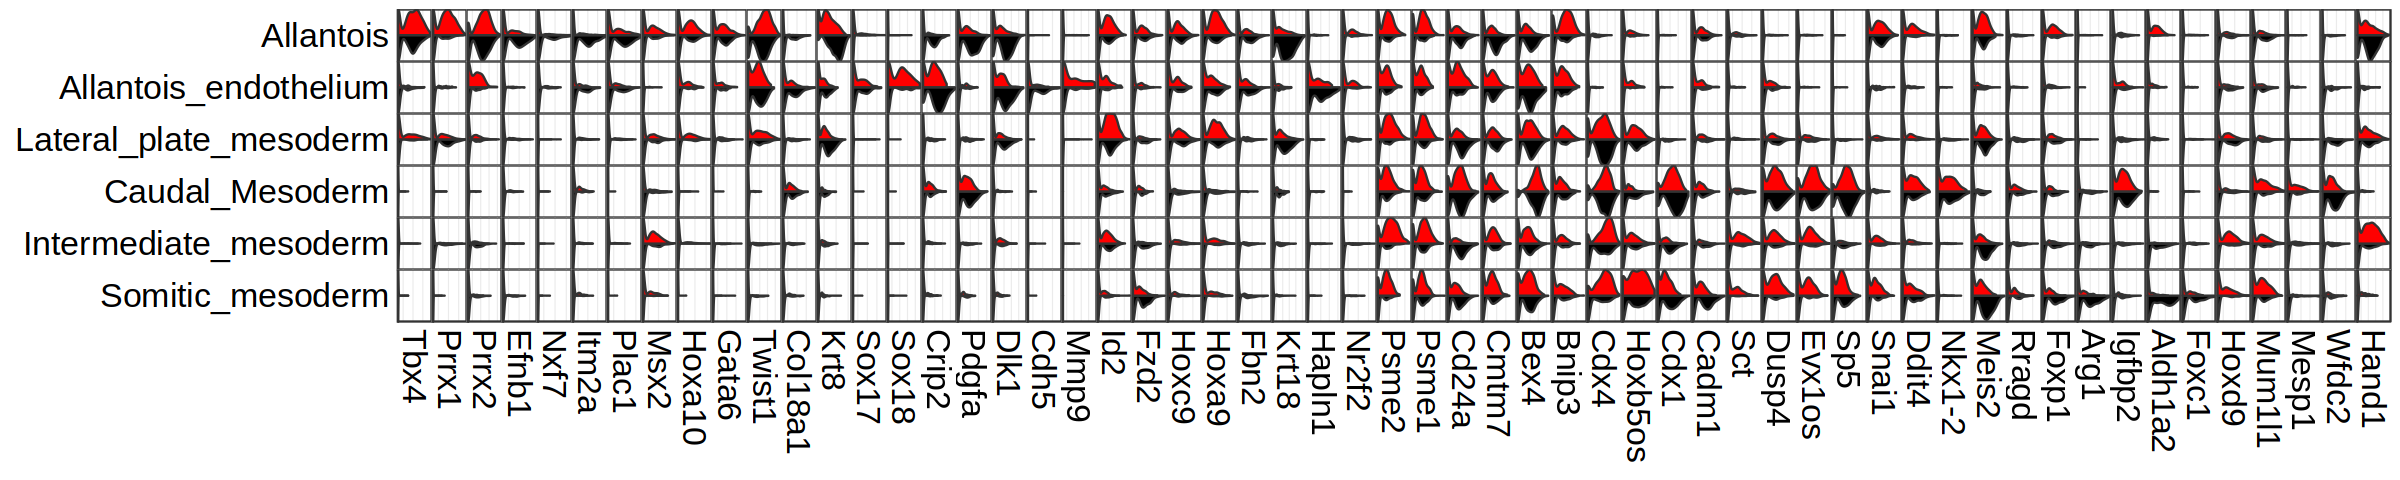

In [17]:
# plot genes that are significant in at least one of the cell types
quantile_cutoff = 0.9995
celltypes = c('Allantois','Allantois_endothelium','Lateral_plate_mesoderm','Caudal_Mesoderm', 'Intermediate_mesoderm', 'Somitic_mesoderm')
gene_list = unique(c(
    
              'Tbx4', 'Prrx1', 'Prrx2','Efnb1', 'Nxf7','Itm2a', 'Plac1', 'Msx2', 'Hoxa10', 'Gata6',
     'Twist1', 'Col18a1', 'Krt8',  'Sox17', 'Sox18','Crip2','Pdgfa','Dlk1', 'Cdh5', 'Mmp9', 'Id2', 'Fzd2','Hoxc9',  'Hoxa9', 'Fbn2','Krt18', 'Hapln1','Nr2f2',
           'Psme2', 'Psme1', 'Cd24a', 'Cmtm7','Bex4', 'Bnip3', 'Cdx4', 'Hoxb5os', 'Cdx1',  
    'Cadm1', 'Sct', 'Dusp4', 'Evx1os',
            'Sp5', 'Snai1', 'Ddit4', 'Nkx1-2',  
               'Meis2', 'Rragd', 'Foxp1', 'Arg1',  'Igfbp2', 'Aldh1a2', 
              'Foxc1', 'Hoxd9', 'Mum1l1',  'Mesp1',
             'Wfdc2',   'Hand1'
              
))
              
             #  'Igfbp5','Cdkn1c', 'Sox18', 'Mmp9', 'Itm2a', 'Ddit4', 'Snai1', 'Ldhb', 'Podxl', 'Prrx1', 'Prrx2', 'Bnip1', 'Cdx4', 'Wnt5a',
             # 'Hand1', 'Meis2', 'Evx1os', 'Hoxa9', 'Bmp4')

test = mclapply(gene_list, function(x){
    tmp = sample_metadata %>% copy() %>%
        .[,gene:=as.vector(logcounts(sce[x,]))] %>% .[,gene_name :=x] %>%
        .[,gene_quantcutoff:=ifelse(gene > quantile(gene, quantile_cutoff), quantile(gene, quantile_cutoff), gene)]
    return(tmp)
}, mc.cores=16) %>% rbindlist() %>% 
    .[,variable := ifelse(variable %in% celltypes, variable, 'Other'),] %>% 
    .[,variable := factor(variable, levels = c(celltypes, 'Other'))] %>% 
    .[,gene_name := factor(gene_name, levels = gene_list)] %>% 
    .[variable != 'Other']

options(repr.plot.width=20, repr.plot.height=4)
#test$gene = test$gene + rnorm(n = nrow(test))/10 # Seurat adds noise to make violins look better??
suppressWarnings({ggplot(test, aes('x', gene_quantcutoff, fill=tdTom)) + 
    geom_split_violin(scale='width') + 
 #  geom_violin(trim=TRUE, scale = "width") +
    coord_flip() + 
    scale_x_discrete(expand = c(0, 0)) +
    facet_grid(rows = vars(variable), cols=vars(gene_name), switch="both", scales='free_x') + 
    scale_fill_manual(values=c('TRUE'='red', 'FALSE' = 'black')) + 
    theme_bw() + 
    theme(axis.text=element_blank(),
          axis.ticks = element_blank(),
          axis.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.border = element_rect(),
          strip.background = element_blank(),
          strip.text.x = element_text(angle=-90, hjust=0, vjust=0.5, color='black', size=20),
          strip.text.y.left = element_text(angle=0, hjust=1, vjust=0.5, color='black', size=20),
          legend.position='none',
         panel.spacing=unit(0, "lines"))
})

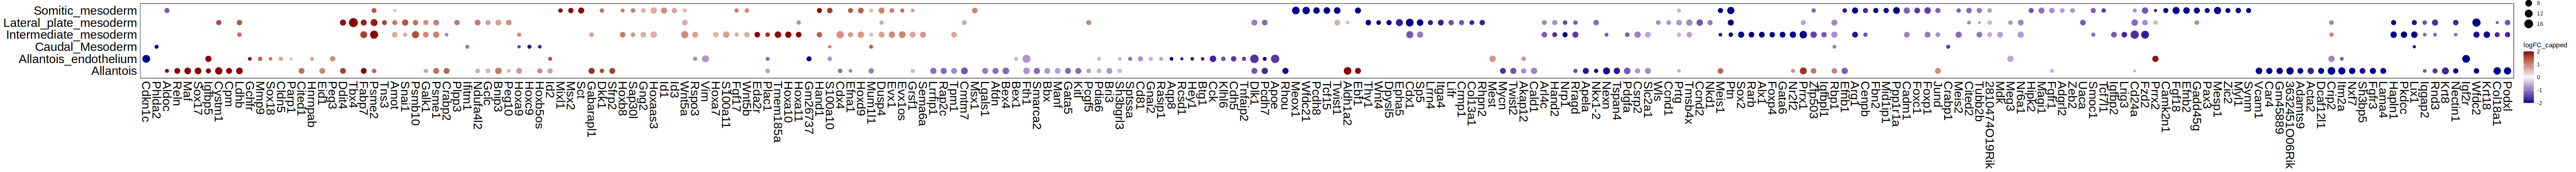

In [67]:
celltypes = c('Allantois','Allantois_endothelium','Lateral_plate_mesoderm','Caudal_Mesoderm', 'Intermediate_mesoderm', 'Somitic_mesoderm')
gene_list = unique(de.results %>% .[sig==TRUE] %>% .[variable %in% celltypes] %>% 
               # .[order(-abs(logFC))] %>% 
                .[order(padj_fdr)] %>% 
                .[,head(.SD, 60), by=variable] %>% .$gene)

# Turn dt in matrix
DEGs.mtx = de.results[gene %in% gene_list & variable %in% celltypes ,c('gene',  'logFC', 'variable')] %>% dcast(., variable ~ gene, value.var = 'logFC')
DEGs.mtx[is.na(DEGs.mtx)] = 0
DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('variable')

# Cluster genes by logFC
order = hclust(dist(t(DEGs.mtx)))

to.plot = de.results %>% copy() %>% 
    .[variable %in% celltypes & gene %in% gene_list] %>% 
    .[, gene := factor(gene, levels = gene_list)] %>% 
    .[, gene := factor(gene, levels = order$labels[order$order])] %>%
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                             ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=60, repr.plot.height=4)
ggplot(to.plot[sig==T], aes(gene, variable, color = logFC_capped, size = -log10(padj_fdr))) + 
    geom_point() + 
    scale_color_gradient2(low = 'darkblue', mid = 'grey97', high = 'darkred') +
    theme_bw() + 
    theme(#axis.text=element_blank(),
          axis.ticks = element_blank(),
          axis.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.border = element_rect(),
          axis.text = element_text(size = 20, color = 'black'),
          axis.text.x = element_text(angle = -90, hjust = 0, vjust = 0.5)
    )

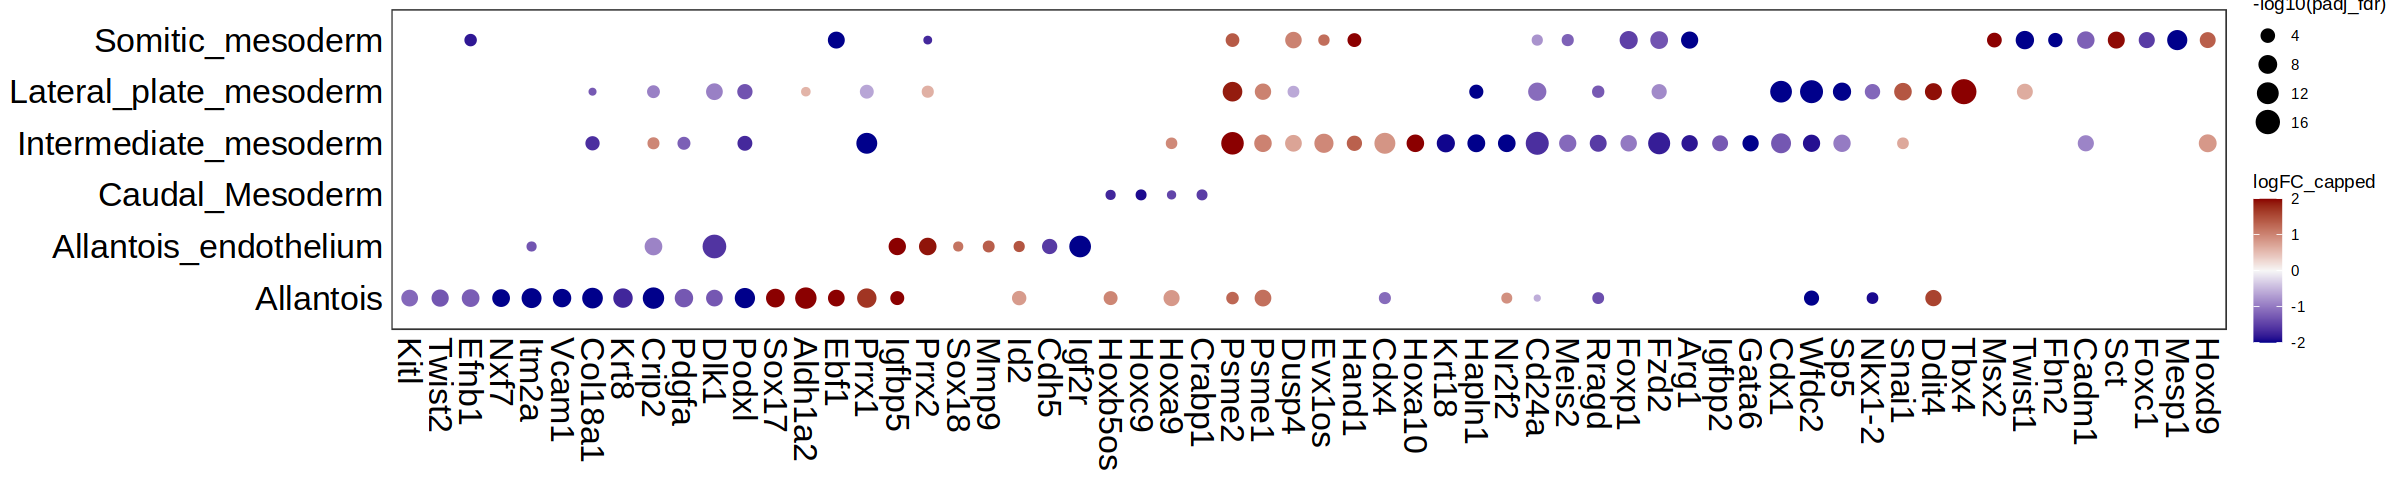

In [109]:
celltypes = c('Allantois','Allantois_endothelium','Lateral_plate_mesoderm','Caudal_Mesoderm', 'Intermediate_mesoderm', 'Somitic_mesoderm')
gene_list = unique(c(   
    'Kitl', 'Twist2', 'Efnb1', 'Nxf7','Itm2a', 'Vcam1','Col18a1', 'Krt8', 'Crip2','Pdgfa','Dlk1', 'Podxl',   'Sox17', 'Aldh1a2', 'Ebf1', 'Prrx1','Igfbp5', 
    'Prrx2', 'Sox18', 'Mmp9',  'Id2', 'Prrx2', 'Cdh5', 'Igf2r',
    'Hoxb5os','Hoxc9',  'Hoxa9', 'Crabp1',
    'Psme2', 'Psme1','Dusp4', 'Evx1os', 'Hand1','Cdx4',  'Hoxa10',  'Krt18', 'Hapln1','Nr2f2','Cd24a', 'Meis2', 'Rragd', 'Foxp1','Fzd2', 'Arg1',  'Igfbp2', 'Gata6',
    'Cdx1', 'Wfdc2', 'Sp5', 'Nkx1-2',  'Snai1', 'Ddit4','Tbx4',
    'Msx2', 'Twist1',   'Fbn2','Cadm1', 'Sct', 'Foxc1',  'Mesp1',  'Aldh1a2', 'Hoxd9'
    
))

to.plot = de.results %>% copy() %>% 
    .[variable %in% celltypes & gene %in% gene_list] %>% 
    .[, gene := factor(gene, levels = gene_list)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                             ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=20, repr.plot.height=4)
ggplot(to.plot[sig==T], aes(gene, variable, color = logFC_capped, size = -log10(padj_fdr))) + 
    geom_point() + 
    scale_color_gradient2(low = 'darkblue', mid = 'grey97', high = 'darkred') +
    theme_bw() + 
    theme(#axis.text=element_blank(),
          axis.ticks = element_blank(),
          axis.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.border = element_rect(),
          axis.text = element_text(size = 20, color = 'black'),
          axis.text.x = element_text(angle = -90, hjust = 0, vjust = 0.5)
    )

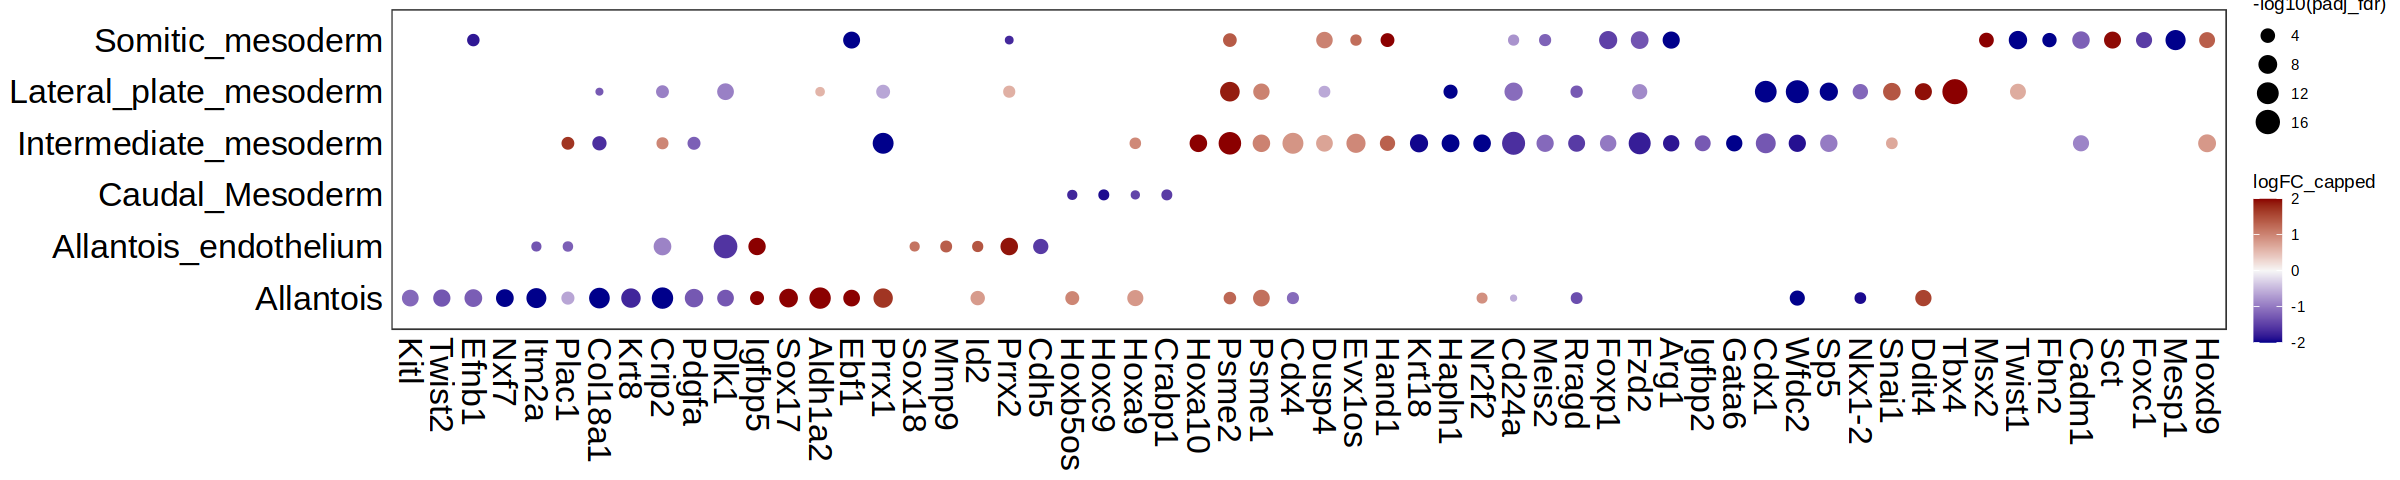

In [103]:
celltypes = c('Allantois','Allantois_endothelium','Lateral_plate_mesoderm','Caudal_Mesoderm', 'Intermediate_mesoderm', 'Somitic_mesoderm')
gene_list = unique(c(   
    'Kitl', 'Twist2', 'Efnb1', 'Nxf7','Itm2a', 'Plac1','Col18a1', 'Krt8', 'Crip2','Pdgfa','Dlk1', 'Igfbp5',  'Sox17', 'Aldh1a2', 'Ebf1', 'Prrx1',
    'Sox18', 'Mmp9',  'Id2', 'Prrx2', 'Cdh5',
    'Hoxb5os','Hoxc9',  'Hoxa9', 'Crabp1',
    'Hoxa10','Psme2', 'Psme1',  'Cdx4', 'Dusp4', 'Evx1os', 'Hand1', 'Krt18', 'Hapln1','Nr2f2','Cd24a', 'Meis2', 'Rragd', 'Foxp1','Fzd2', 'Arg1',  'Igfbp2', 'Gata6',
    'Cdx1', 'Wfdc2', 'Sp5', 'Nkx1-2',  'Snai1', 'Ddit4','Tbx4',
    'Msx2', 'Twist1',   'Fbn2','Cadm1', 'Sct', 'Foxc1',  'Mesp1',  'Aldh1a2', 'Hoxd9'
    
))

to.plot = de.results %>% copy() %>% 
    .[variable %in% celltypes & gene %in% gene_list] %>% 
    .[, gene := factor(gene, levels = gene_list)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                             ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=20, repr.plot.height=4)
ggplot(to.plot[sig==T], aes(gene, variable, color = logFC_capped, size = -log10(padj_fdr))) + 
    geom_point() + 
    scale_color_gradient2(low = 'darkblue', mid = 'grey97', high = 'darkred') +
    theme_bw() + 
    theme(#axis.text=element_blank(),
          axis.ticks = element_blank(),
          axis.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.border = element_rect(),
          axis.text = element_text(size = 20, color = 'black'),
          axis.text.x = element_text(angle = -90, hjust = 0, vjust = 0.5)
    )

# TO-DO: Gene Ontology for the different cell-types, or at least for Allantois

### Not specific but all genes

In [22]:
# specific genes
# Genes are tested to be significantly different from the average LFC of all cell-types
de.results <- pseudoBulkDGE(summed.filt, 
    label=summed.filt$variable,
    design=~factor(pool) + tdTom,
    lfc = 0.5,
    coef="tdTomTRUE",
    condition=summed.filt$tdTom
    ) %>% unlist() %>% 
        as.data.table(keep.rownames=T) %>%
        .[,`:=`(gene=str_split(rn, '\\.') %>% map_chr(2), # extract gene names
                variable=str_split(rn, '\\.') %>% map_chr(1), # extract cell type
                rn=NULL, 
                sig=ifelse(abs(logFC)>=0.5 & FDR<=0.05, TRUE, FALSE))] %>%  # significance
        .[!is.na(logFC),] %>%
        setnames('FDR', 'padj_fdr')

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


In [23]:
fwrite(de.results, file.path(args$outdir, 'pseudoBulkAll.txt.gz'))

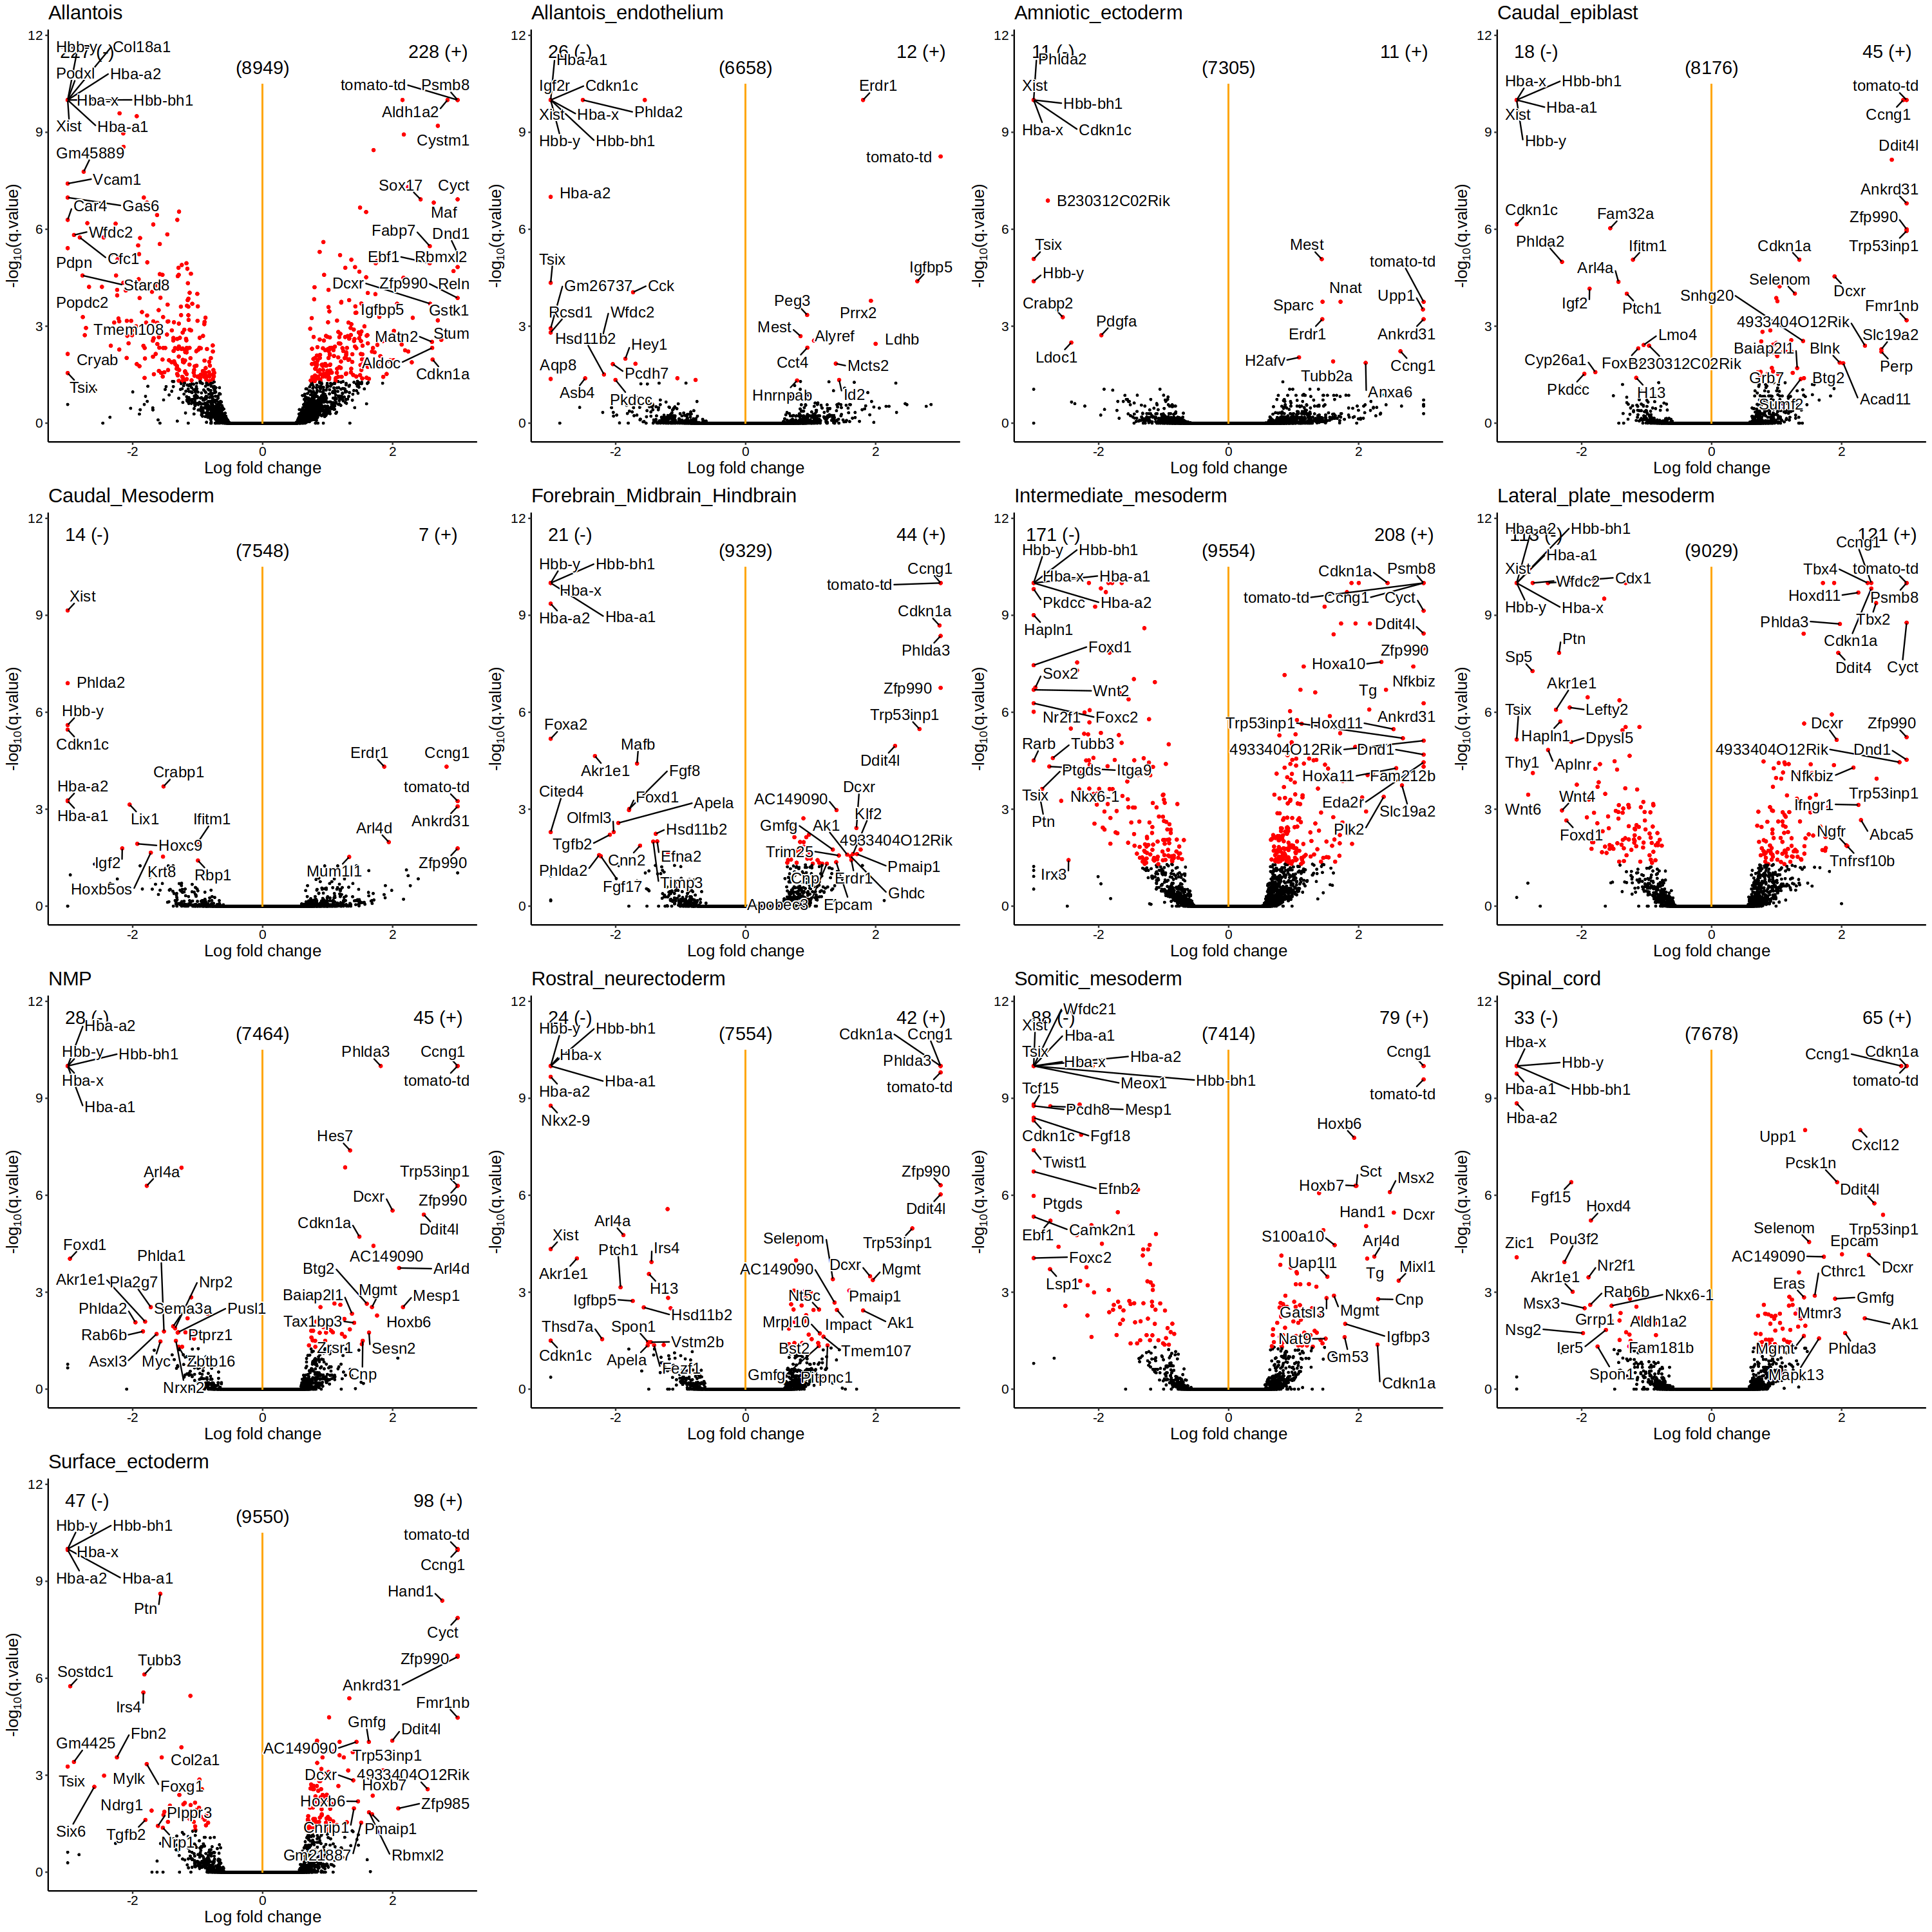

In [24]:
# Make plots
plots = lapply(unique(de.results$variable),gg_volcano_plot, ylim=10, xlim=3)
combined_plot <- cowplot::plot_grid(plotlist = plots, ncol = 4)
options(repr.plot.width=25, repr.plot.height=25)
combined_plot

### Little test

In [5]:
de.results = fread(file.path(args$outdir, 'pseudoBulkSpecific.txt.gz'))

In [75]:
head(de.results)

logFC      logCPM   F           PValue       padj_fdr     OtherAverage
1  2.4300800 4.693565 118.3691169 1.717675e-11 1.280956e-08 -0.38042566 
2  0.1141347 7.647249   1.4512978 8.572185e-01 1.000000e+00  0.09694575 
3  0.1685335 4.624626   0.8422278 7.643426e-01 1.000000e+00  0.11301293 
4 -0.1891444 7.271503   3.4604979 2.925666e-01 7.569176e-01 -0.08013203 
5  0.1165797 5.195631   0.5648115 1.000000e+00 1.000000e+00  0.18470133 
6  0.2197346 6.039628   1.8795368 1.855267e-01 6.032989e-01 -0.08676637 
  gene    variable  sig  
1 Sox17   Allantois  TRUE
2 Mrpl15  Allantois FALSE
3 Lypla1  Allantois FALSE
4 Tcea1   Allantois FALSE
5 Atp6v1h Allantois FALSE
6 Rb1cc1  Allantois FALSE

In [83]:
plot_gene_UMAP = function(gene, sig_only=T){
    gene_i = gene
    tmp = sample_metadata %>% copy() %>% .[, c('umapX', 'umapY', 'variable')] %>% 
        merge(., de.results[gene==gene_i][,c('variable', 'sig', 'logFC', 'padj_fdr')], by='variable', all.x=TRUE) %>% 
        .[,sig := ifelse(padj_fdr < 0.05, TRUE, FALSE)] %>%  # significance only based on p-value instead of logFC too
        .[, color := logFC] %>%
        .[, logFC := ifelse(is.na(logFC), 0, logFC)]
    tmp = tmp[order(abs(logFC))]
    
    if(sig_only==T){
        tmp = tmp[, color := ifelse(sig==TRUE, logFC, 0)]        
    }
    
    p = ggplot(tmp, aes(umapX, umapY, color=color)) + 
            geom_point() +
            scale_color_gradient2(low='darkblue', mid='grey90', high='darkred') + 
            theme_void()
    return(p)
}

In [115]:
sce

class: SingleCellExperiment 
dim: 29453 28723 
metadata(0):
assays(2): counts logcounts
rownames(29453): Xkr4 Gm1992 ... CAAA01147332.1 tomato-td
rowData names(0):
colnames(28723): SLX-20795_SITTH10_HKTG2DRXY#GTTCATTTCACCCTGT-1
  SLX-20795_SITTG11_HKTG2DRXY#ATAGAGACATATGGCT-1 ...
  SLX-20795_SITTB11_HKTG2DRXY#CTACCCATCTCGTGGG-1
  SLX-20795_SITTB11_HKTG2DRXY#AAAGGATAGGTACAAT-1
colData names(25): closest.cell_mnn sample ... pool variable
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

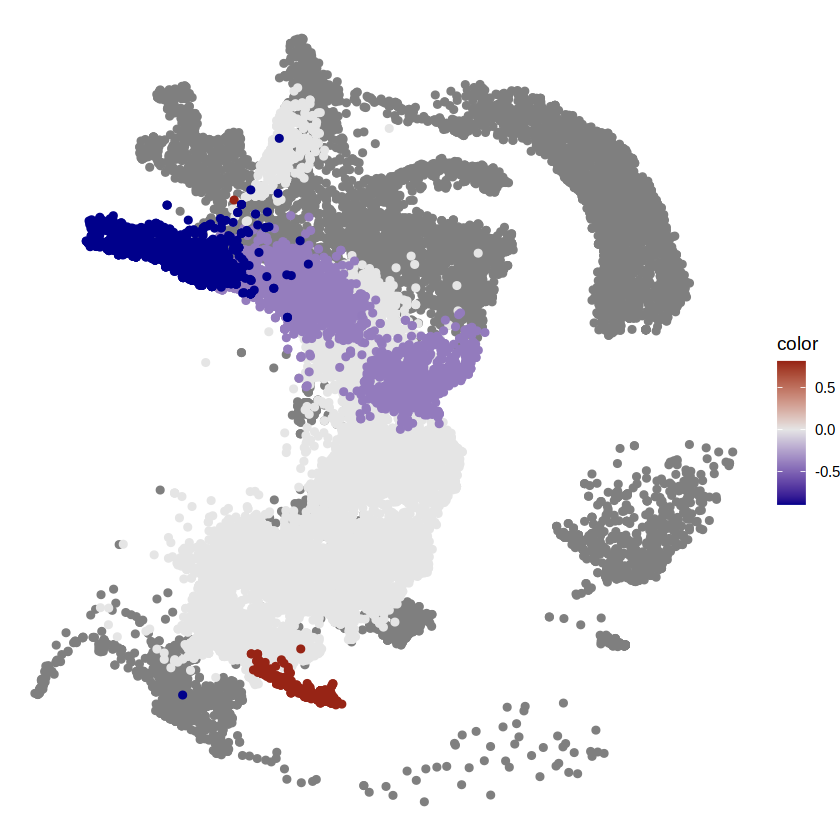

In [114]:
plot_gene_UMAP('Cald1', sig_only = T)

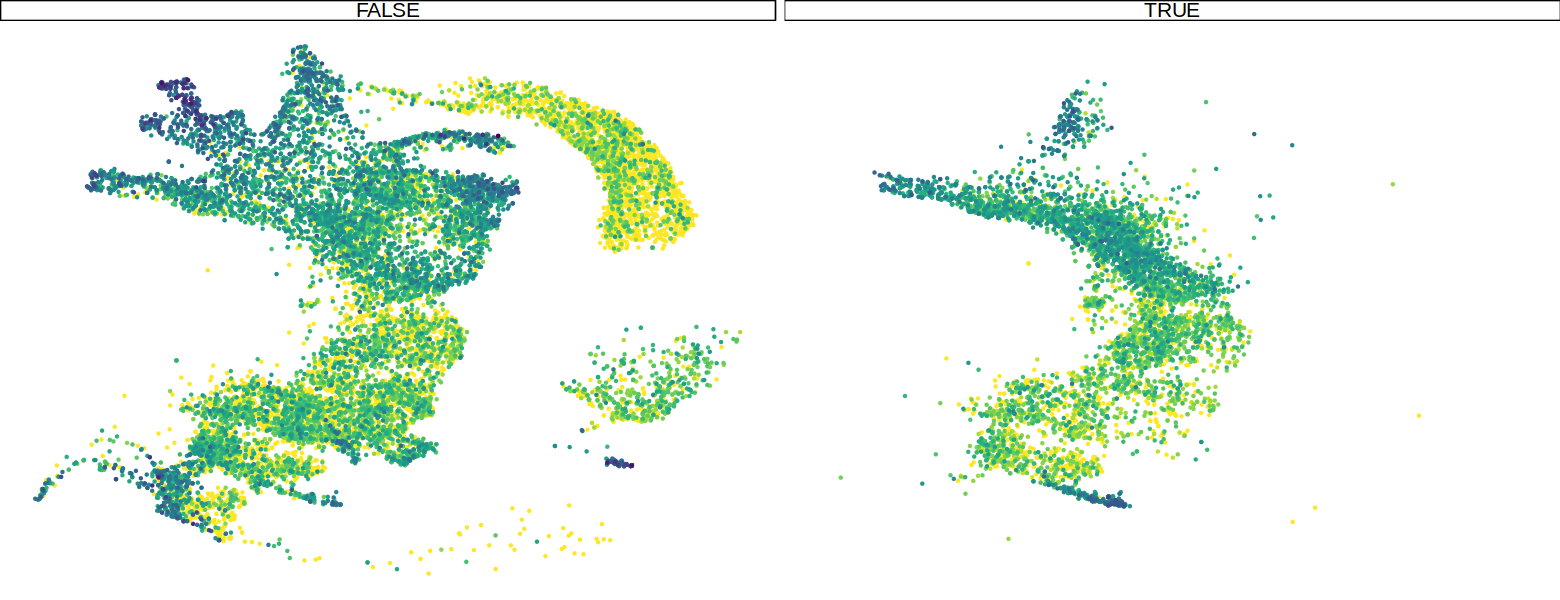

In [117]:
options(repr.plot.height=5, repr.plot.width=13)

tmp = as.data.table(sample_metadata) %>% .[,gene := as.vector(logcounts(sce['Cald1',]))] %>% 
    .[order(gene)]
p = ggplot(tmp , aes(x = umapX, y = umapY , col = gene)) +
  geom_point(size=0.2) + 
  viridis::scale_color_viridis(begin=1, end=0) +
  facet_wrap(~tdTom) +
  theme_void() + 
  theme(legend.position='none',
       strip.background=element_rect(fill=NA),
       text=element_text(size=15)) + 
  labs(x = "UMAP-1", y = "UMAP-2")
p

# Gene ontology

In [111]:
suppressPackageStartupMessages({
    library(biomaRt)
    library(limma)
    library(org.Mm.eg.db)
})

# mm10mart <- useMart(dataset = "mmusculus_gene_ensembl", biomart = "ensembl")
# mapping <- getBM(
#   attributes = c('hgnc_symbol', 'ensembl_gene_id', 'entrezgene_id', 'external_gene_name'), 
#   mart = mm10mart
# )
# mapping = as.data.table(mapping)
# fwrite(mapping, '/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/Mmusculus_genes_BioMart.07052024.txt')
mapping = fread('/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/Mmusculus_genes_BioMart.07052024.txt')

In [242]:
genes = de.results[variable=='Allantois' & sig == TRUE & logFC <0, gene]

In [243]:
# Retrieve GO
go = as.data.table(goana(mapping[match(genes, external_gene_name),entrezgene_id], species="Mm"), keep.rownames=T) %>% setnames('rn', 'GOALL') %>% 
    .[order(P.DE)] %>%
    .[,FDR := p.adjust(P.DE, method = 'fdr')] %>% 
    .[P.DE < 0.1] %>% 
    .[, enrichment := (length(genes)/N) / (N/32285)] %>%  # 32285 = nrow(rna.sce) # Enrichment should be depending on the number of genes in the term
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)] # set threshold for enrichment at 100
# Add gene names to annotations
GO_genes = AnnotationDbi::select(org.Mm.eg.db, keytype="GOALL", keys=go[, GOALL], columns='ENTREZID') %>% 
    as.data.table() %>% 
    .[, EVIDENCEALL := NULL] %>% 
    unique() %>% 
    merge(., mapping[,c('entrezgene_id', 'external_gene_name')] %>% 
              .[, entrezgene_id := as.character(entrezgene_id)],
          by.x = 'ENTREZID', by.y = 'entrezgene_id')
# Add genes into GO list
go = mclapply(1:nrow(go), function(x){ # nrow(go)
    GO_genes_tmp = GO_genes[GOALL == go[x, GOALL], external_gene_name]
    genes_GO = intersect(GO_genes_tmp, genes)
    tmp = go[x,] %>% .[, `:=`(genes = paste0(genes_GO, collapse = ', '),
                              N = length(intersect(rownames(sce), GO_genes_tmp)))] %>%  # Ntot is only the number of genes in the GO that are also in the SCE object
    .[,enrichment := (DE/N)/(N/32285)] %>% 
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)]
}, mc.cores = 10) %>% rbindlist()

'select()' returned 1:many mapping between keys and columns



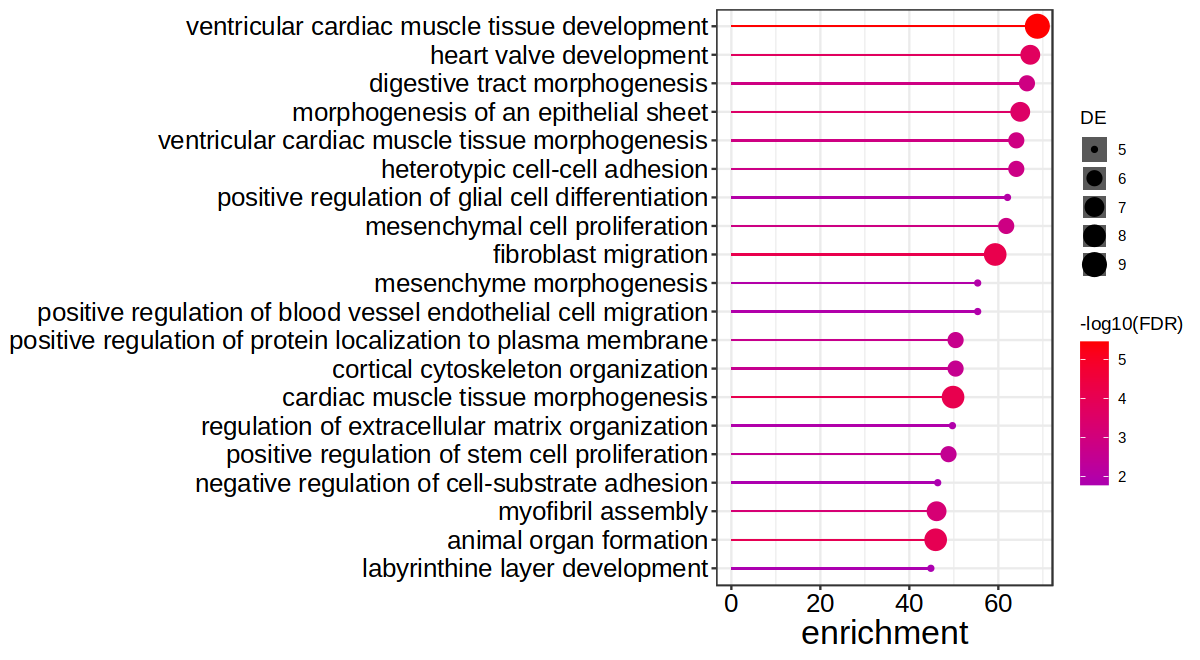

In [252]:
options(repr.plot.width=10, repr.plot.height=5.5)
plot = go %>% copy() %>%
       .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 50] %>% .[order(-enrichment)] %>% 
        .[,Term := factor(Term, levels = rev(Term))] %>% 
        head(20)
ggplot(plot, 
       aes(enrichment, Term, color = -log10(FDR), size = DE)) + 
    geom_bar(stat = 'identity', aes(fill = -log10(FDR)), color = NA,  width = 0.05) +
    geom_point() + 
    scale_color_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    scale_fill_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    xlim(0, max(plot$enrichment)) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_blank())

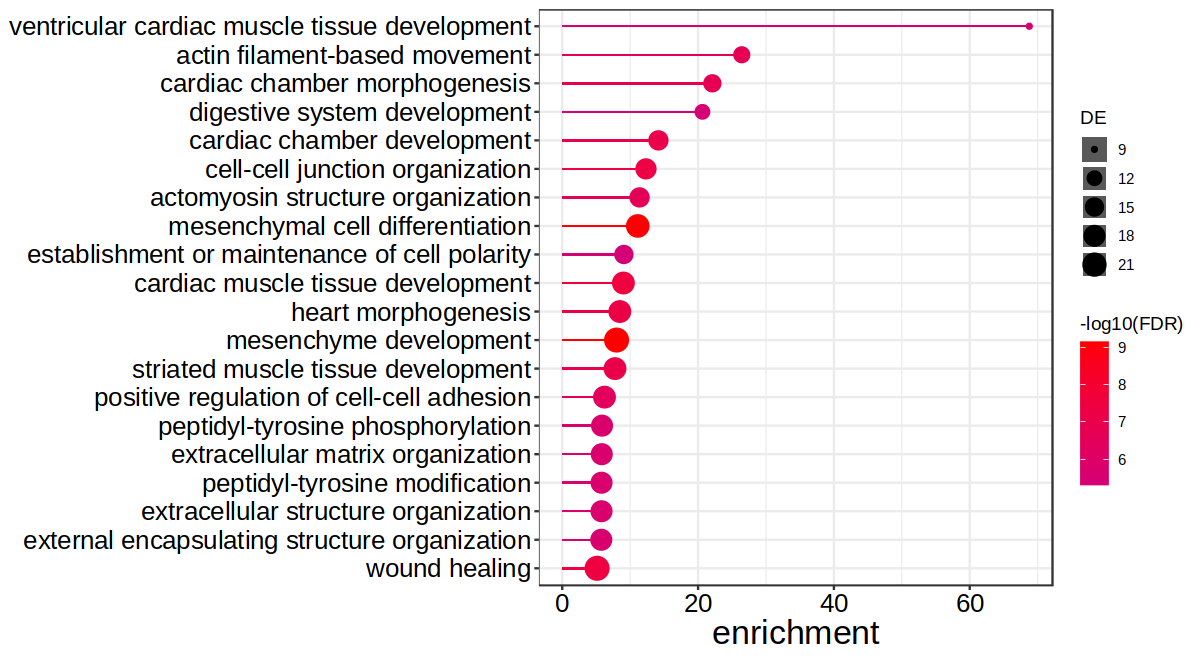

In [279]:
options(repr.plot.width=10, repr.plot.height=5.5)
plot = go %>% copy() %>% 
       .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 50 & N < 1000 & DE > 5 & enrichment > 5] %>% .[order(FDR)] %>% 
        head(20) %>% 
        .[order(-enrichment)] %>% 
        .[,Term := factor(Term, levels = rev(Term))]

ggplot(plot, 
       aes(enrichment, Term, color = -log10(FDR), size = DE)) + 
    geom_bar(stat = 'identity', aes(fill = -log10(FDR)), color = NA,  width = 0.05) +
    geom_point() + 
    scale_color_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    scale_fill_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    xlim(0, max(plot$enrichment)) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_blank())

In [280]:
genes = de.results[variable=='Allantois' & sig == TRUE & logFC > 0, gene]

In [281]:
# Retrieve GO
go = as.data.table(goana(mapping[match(genes, external_gene_name),entrezgene_id], species="Mm"), keep.rownames=T) %>% setnames('rn', 'GOALL') %>% 
    .[order(P.DE)] %>%
    .[,FDR := p.adjust(P.DE, method = 'fdr')] %>% 
    .[P.DE < 0.1] %>% 
    .[, enrichment := (length(genes)/N) / (N/32285)] %>%  # 32285 = nrow(rna.sce) # Enrichment should be depending on the number of genes in the term
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)] # set threshold for enrichment at 100
# Add gene names to annotations
GO_genes = AnnotationDbi::select(org.Mm.eg.db, keytype="GOALL", keys=go[, GOALL], columns='ENTREZID') %>% 
    as.data.table() %>% 
    .[, EVIDENCEALL := NULL] %>% 
    unique() %>% 
    merge(., mapping[,c('entrezgene_id', 'external_gene_name')] %>% 
              .[, entrezgene_id := as.character(entrezgene_id)],
          by.x = 'ENTREZID', by.y = 'entrezgene_id')
# Add genes into GO list
go = mclapply(1:nrow(go), function(x){ # nrow(go)
    GO_genes_tmp = GO_genes[GOALL == go[x, GOALL], external_gene_name]
    genes_GO = intersect(GO_genes_tmp, genes)
    tmp = go[x,] %>% .[, `:=`(genes = paste0(genes_GO, collapse = ', '),
                              N = length(intersect(rownames(sce), GO_genes_tmp)))] %>%  # Ntot is only the number of genes in the GO that are also in the SCE object
    .[,enrichment := (DE/N)/(N/32285)] %>% 
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)]
}, mc.cores = 10) %>% rbindlist()

'select()' returned 1:many mapping between keys and columns



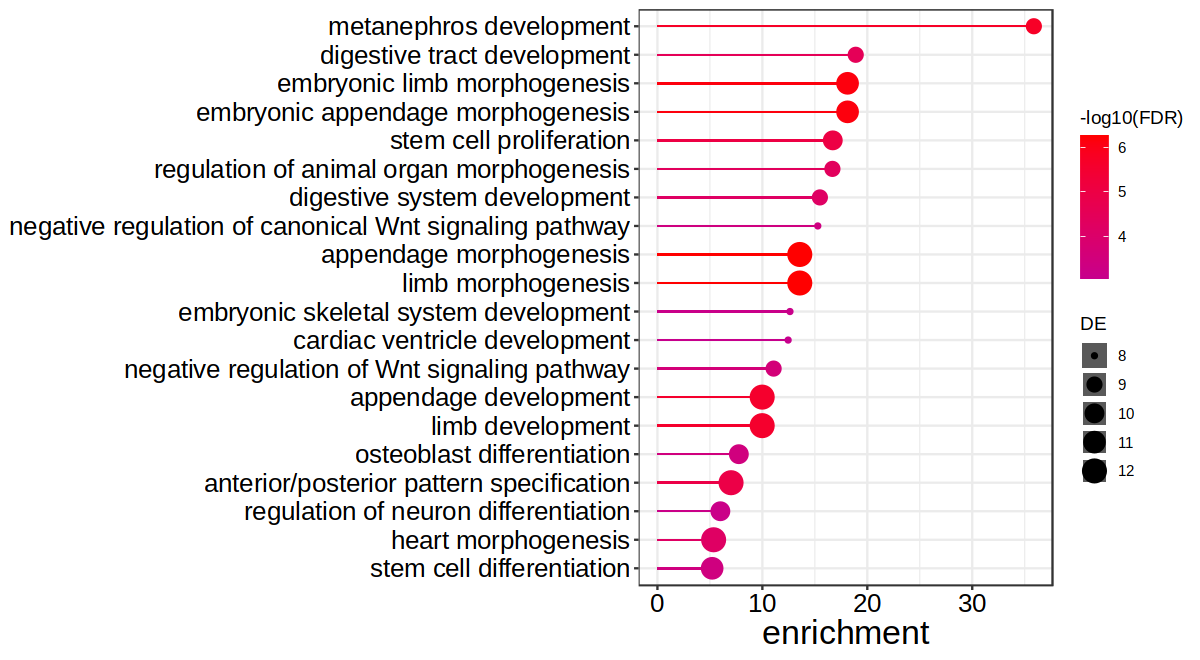

In [282]:
options(repr.plot.width=10, repr.plot.height=5.5)
plot = go %>% copy() %>% 
       .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 50 & N < 1000 & DE > 5 & enrichment > 5] %>% .[order(FDR)] %>% 
        head(20) %>% 
        .[order(-enrichment)] %>% 
        .[,Term := factor(Term, levels = rev(Term))]

ggplot(plot, 
       aes(enrichment, Term, color = -log10(FDR), size = DE)) + 
    geom_bar(stat = 'identity', aes(fill = -log10(FDR)), color = NA,  width = 0.05) +
    geom_point() + 
    scale_color_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    scale_fill_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    xlim(0, max(plot$enrichment)) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_blank())

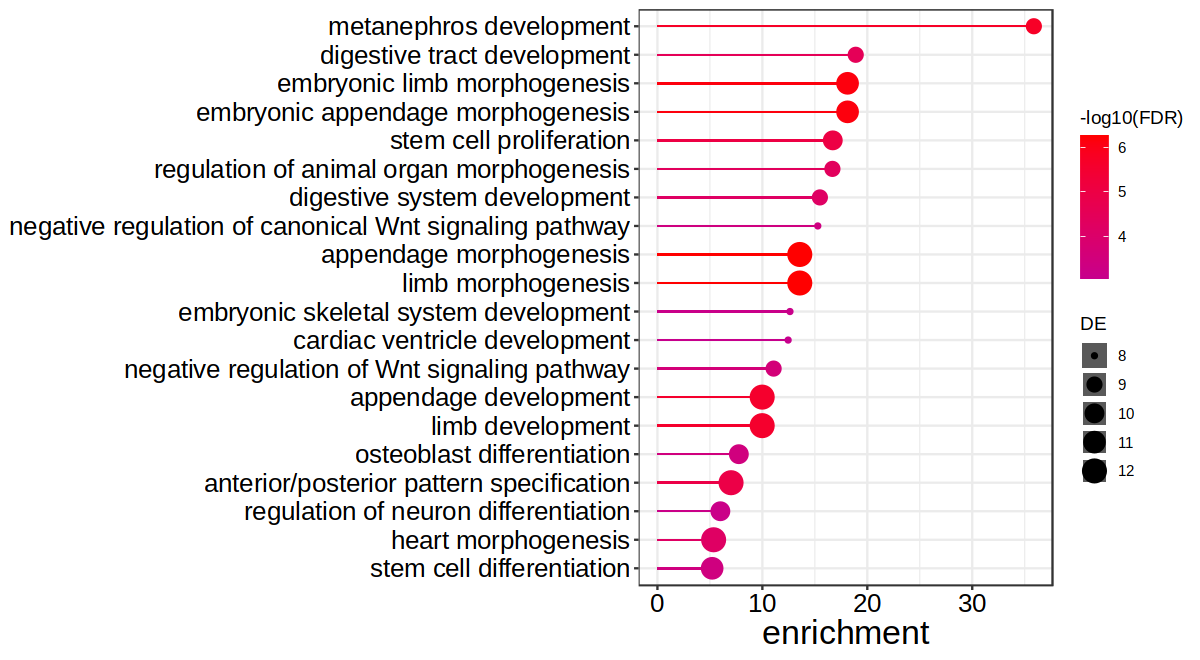

In [284]:
options(repr.plot.width=10, repr.plot.height=5.5)
plot = go %>% copy() %>% 
       .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 50 & N < 1000 & DE > 5 & enrichment > 5] %>% .[order(FDR)] %>% 
        head(20) %>% 
        .[order(-enrichment)] %>% 
        .[,Term := factor(Term, levels = rev(Term))]

ggplot(plot, 
       aes(enrichment, Term, color = -log10(FDR), size = DE)) + 
    geom_bar(stat = 'identity', aes(fill = -log10(FDR)), color = NA,  width = 0.05) +
    geom_point() + 
    scale_color_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    scale_fill_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    xlim(0, max(plot$enrichment)) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_blank())

In [285]:
genes = de.results[variable=='Intermediate_mesoderm' & sig == TRUE & logFC <0, gene]

In [286]:
# Retrieve GO
go = as.data.table(goana(mapping[match(genes, external_gene_name),entrezgene_id], species="Mm"), keep.rownames=T) %>% setnames('rn', 'GOALL') %>% 
    .[order(P.DE)] %>%
    .[,FDR := p.adjust(P.DE, method = 'fdr')] %>% 
    .[P.DE < 0.1] %>% 
    .[, enrichment := (length(genes)/N) / (N/32285)] %>%  # 32285 = nrow(rna.sce) # Enrichment should be depending on the number of genes in the term
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)] # set threshold for enrichment at 100
# Add gene names to annotations
GO_genes = AnnotationDbi::select(org.Mm.eg.db, keytype="GOALL", keys=go[, GOALL], columns='ENTREZID') %>% 
    as.data.table() %>% 
    .[, EVIDENCEALL := NULL] %>% 
    unique() %>% 
    merge(., mapping[,c('entrezgene_id', 'external_gene_name')] %>% 
              .[, entrezgene_id := as.character(entrezgene_id)],
          by.x = 'ENTREZID', by.y = 'entrezgene_id')
# Add genes into GO list
go = mclapply(1:nrow(go), function(x){ # nrow(go)
    GO_genes_tmp = GO_genes[GOALL == go[x, GOALL], external_gene_name]
    genes_GO = intersect(GO_genes_tmp, genes)
    tmp = go[x,] %>% .[, `:=`(genes = paste0(genes_GO, collapse = ', '),
                              N = length(intersect(rownames(sce), GO_genes_tmp)))] %>%  # Ntot is only the number of genes in the GO that are also in the SCE object
    .[,enrichment := (DE/N)/(N/32285)] %>% 
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)]
}, mc.cores = 10) %>% rbindlist()

'select()' returned 1:many mapping between keys and columns



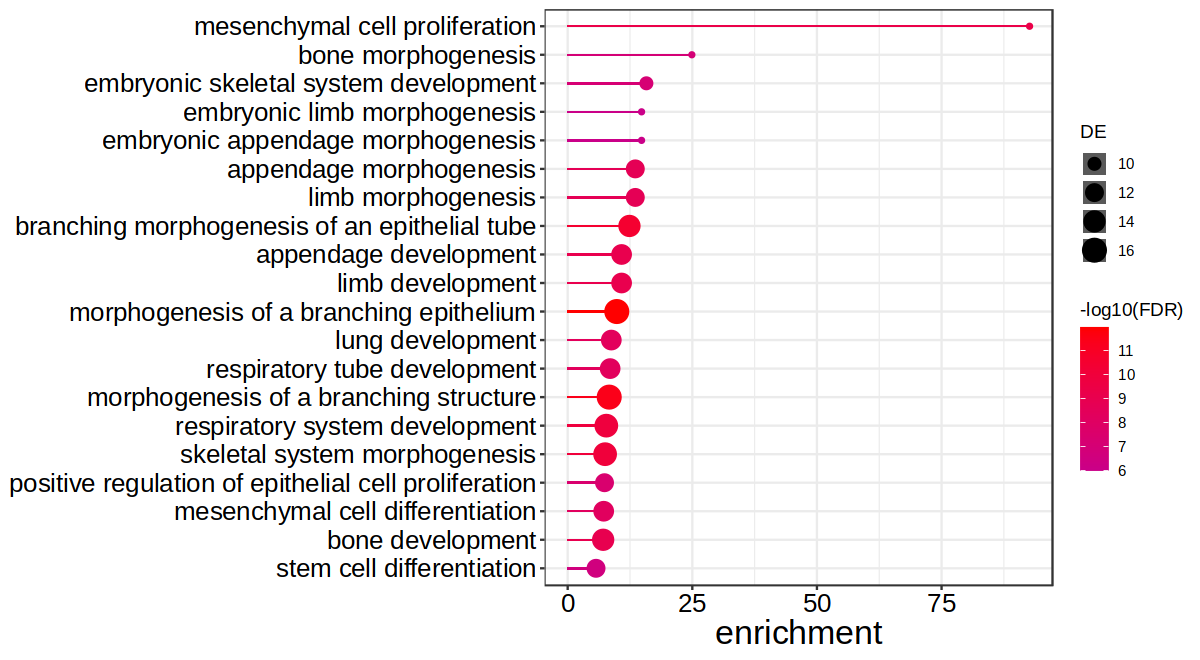

In [287]:
options(repr.plot.width=10, repr.plot.height=5.5)
plot = go %>% copy() %>% 
       .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 50 & N < 1000 & DE > 5 & enrichment > 5] %>% .[order(FDR)] %>% 
        head(20) %>% 
        .[order(-enrichment)] %>% 
        .[,Term := factor(Term, levels = rev(Term))]

ggplot(plot, 
       aes(enrichment, Term, color = -log10(FDR), size = DE)) + 
    geom_bar(stat = 'identity', aes(fill = -log10(FDR)), color = NA,  width = 0.05) +
    geom_point() + 
    scale_color_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    scale_fill_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    xlim(0, max(plot$enrichment)) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_blank())

In [288]:
head(go[FDR < 0.05][Ont == 'BP'][enrichment > 5][order(-DE)])

GOALL      Term                                          Ont N   DE
1 GO:0061138 morphogenesis of a branching epithelium       BP  229 16
2 GO:0001763 morphogenesis of a branching structure        BP  249 16
3 GO:0048705 skeletal system morphogenesis                 BP  254 15
4 GO:0060541 respiratory system development                BP  250 15
5 GO:0048754 branching morphogenesis of an epithelial tube BP  191 14
6 GO:0060348 bone development                              BP  252 14
  P.DE         FDR          enrichment
1 1.939622e-15 1.056494e-12  9.850308 
2 7.230352e-15 3.846715e-12  8.331479 
3 2.690092e-13 1.017208e-10  7.506278 
4 3.741187e-13 1.337299e-10  7.748400 
5 6.240463e-14 2.855261e-11 12.389737 
6 4.003353e-12 9.847819e-10  7.117504 
  genes                                                                                              
1 Col4a1, Fgfr2, Foxc2, Kdr, Mdk, Mmp14, Nrp1, Pbx1, Pdgfa, Pgf, Sfrp1, Sox2, Sox9, Wnt2, Ctsz, Rdh10
2 Col4a1, Fgfr2, Foxc2, Kdr, Mdk, Mmp14, Nrp1, Pbx1, Pdgfa, Pgf, Sfrp1, Sox2, Sox9, Wnt2, Ctsz, Rdh10
3 Cdx1, Col1a1, Fgfr2, Foxc2, Mmp14, Prrx1, Sfrp1, Ski, Sox9, Alx1, Rarb, Irx5, Sp5, Ifitm5, Rdh10   
4 Pkdcc, Foxp1, Speg, Fgfr2, Gata6, Kdr, Mmp14, Pdgfa, Ski, Sox2, Sox9, Wnt2, Ctsz, Foxp4, Rdh10     
5 Col4a1, Fgfr2, Foxc2, Kdr, Mdk, Mmp14, Nrp1, Pbx1, Pgf, Sox2, Sox9, Wnt2, Ctsz, Rdh10              
6 Foxp1, Cdx1, Col1a1, Fgfr2, Kdr, Meis1, Mmp14, Pdgfa, Ski, Sox9, Rarb, Cadm1, Sp5, Ifitm5

In [289]:
genes = de.results[variable=='Intermediate_mesoderm' & sig == TRUE & logFC > 0, gene]

In [290]:
# Retrieve GO
go = as.data.table(goana(mapping[match(genes, external_gene_name),entrezgene_id], species="Mm"), keep.rownames=T) %>% setnames('rn', 'GOALL') %>% 
    .[order(P.DE)] %>%
    .[,FDR := p.adjust(P.DE, method = 'fdr')] %>% 
    .[P.DE < 0.1] %>% 
    .[, enrichment := (length(genes)/N) / (N/32285)] %>%  # 32285 = nrow(rna.sce) # Enrichment should be depending on the number of genes in the term
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)] # set threshold for enrichment at 100
# Add gene names to annotations
GO_genes = AnnotationDbi::select(org.Mm.eg.db, keytype="GOALL", keys=go[, GOALL], columns='ENTREZID') %>% 
    as.data.table() %>% 
    .[, EVIDENCEALL := NULL] %>% 
    unique() %>% 
    merge(., mapping[,c('entrezgene_id', 'external_gene_name')] %>% 
              .[, entrezgene_id := as.character(entrezgene_id)],
          by.x = 'ENTREZID', by.y = 'entrezgene_id')
# Add genes into GO list
go = mclapply(1:nrow(go), function(x){ # nrow(go)
    GO_genes_tmp = GO_genes[GOALL == go[x, GOALL], external_gene_name]
    genes_GO = intersect(GO_genes_tmp, genes)
    tmp = go[x,] %>% .[, `:=`(genes = paste0(genes_GO, collapse = ', '),
                              N = length(intersect(rownames(sce), GO_genes_tmp)))] %>%  # Ntot is only the number of genes in the GO that are also in the SCE object
    .[,enrichment := (DE/N)/(N/32285)] %>% 
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)]
}, mc.cores = 10) %>% rbindlist()

'select()' returned 1:many mapping between keys and columns



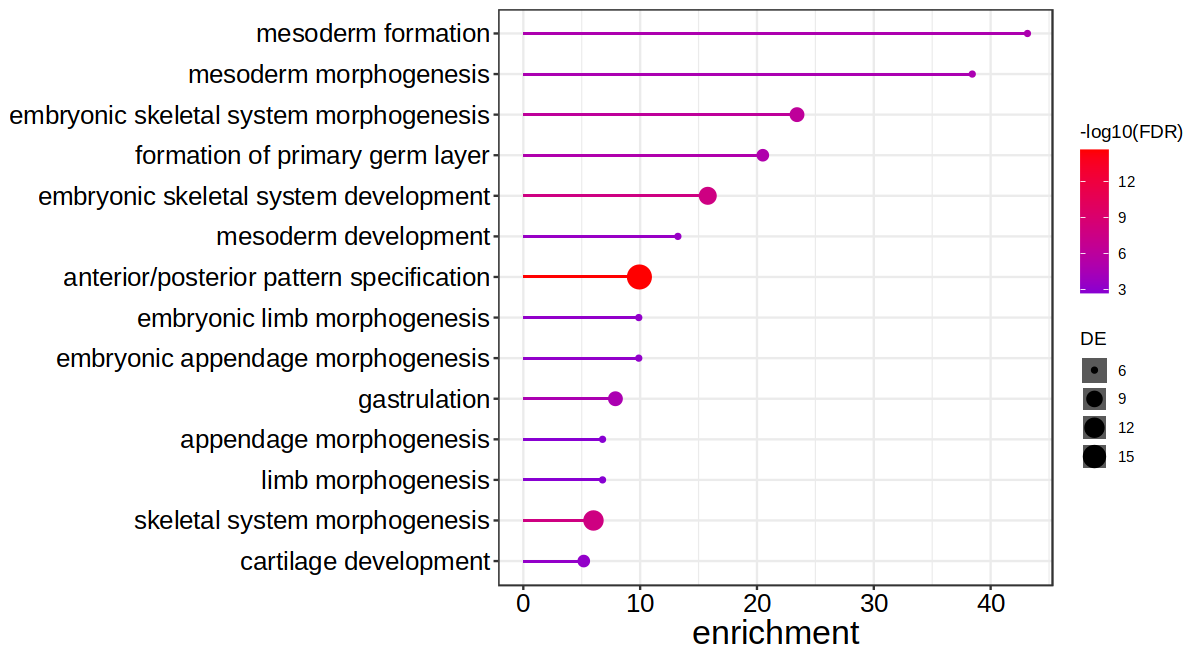

In [291]:
options(repr.plot.width=10, repr.plot.height=5.5)
plot = go %>% copy() %>% 
       .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 50 & N < 1000 & DE > 5 & enrichment > 5] %>% .[order(FDR)] %>% 
        head(20) %>% 
        .[order(-enrichment)] %>% 
        .[,Term := factor(Term, levels = rev(Term))]

ggplot(plot, 
       aes(enrichment, Term, color = -log10(FDR), size = DE)) + 
    geom_bar(stat = 'identity', aes(fill = -log10(FDR)), color = NA,  width = 0.05) +
    geom_point() + 
    scale_color_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    scale_fill_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    xlim(0, max(plot$enrichment)) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_blank())

'select()' returned 1:many mapping between keys and columns



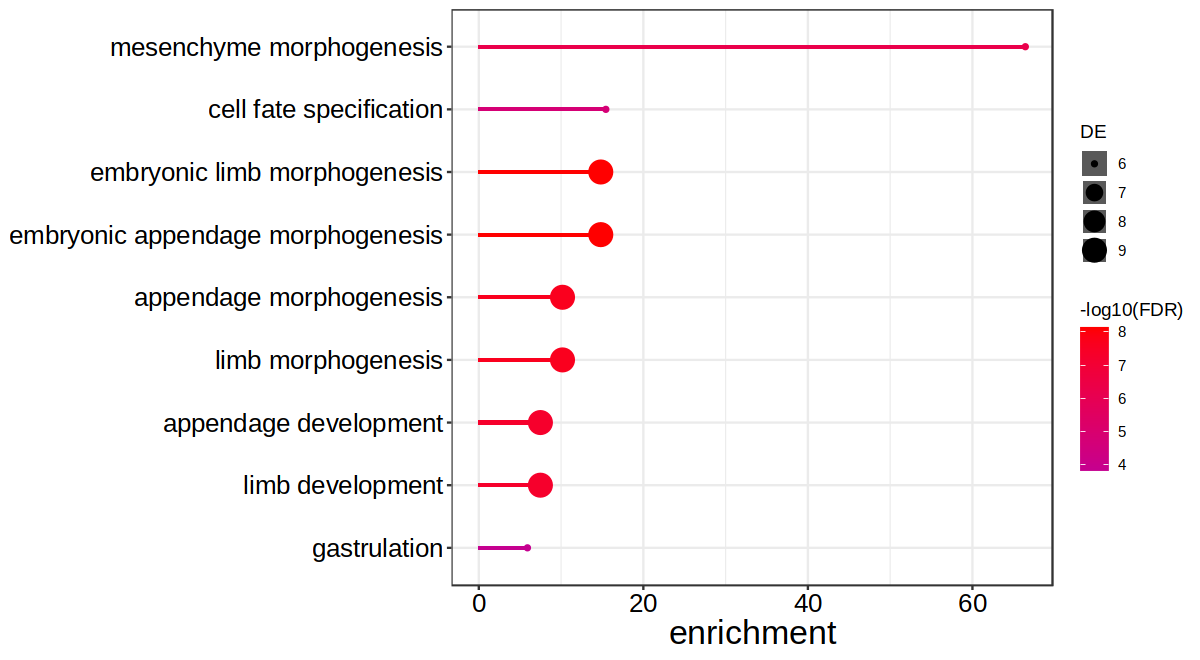

In [300]:
genes = de.results[variable=='Lateral_plate_mesoderm' & sig == TRUE & logFC > 0, gene]

# Retrieve GO
go = as.data.table(goana(mapping[match(genes, external_gene_name),entrezgene_id], species="Mm"), keep.rownames=T) %>% setnames('rn', 'GOALL') %>% 
    .[order(P.DE)] %>%
    .[,FDR := p.adjust(P.DE, method = 'fdr')] %>% 
    .[P.DE < 0.1] %>% 
    .[, enrichment := (length(genes)/N) / (N/32285)] %>%  # 32285 = nrow(rna.sce) # Enrichment should be depending on the number of genes in the term
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)] # set threshold for enrichment at 100
# Add gene names to annotations
GO_genes = AnnotationDbi::select(org.Mm.eg.db, keytype="GOALL", keys=go[, GOALL], columns='ENTREZID') %>% 
    as.data.table() %>% 
    .[, EVIDENCEALL := NULL] %>% 
    unique() %>% 
    merge(., mapping[,c('entrezgene_id', 'external_gene_name')] %>% 
              .[, entrezgene_id := as.character(entrezgene_id)],
          by.x = 'ENTREZID', by.y = 'entrezgene_id')
# Add genes into GO list
go = mclapply(1:nrow(go), function(x){ # nrow(go)
    GO_genes_tmp = GO_genes[GOALL == go[x, GOALL], external_gene_name]
    genes_GO = intersect(GO_genes_tmp, genes)
    tmp = go[x,] %>% .[, `:=`(genes = paste0(genes_GO, collapse = ', '),
                              N = length(intersect(rownames(sce), GO_genes_tmp)))] %>%  # Ntot is only the number of genes in the GO that are also in the SCE object
    .[,enrichment := (DE/N)/(N/32285)] %>% 
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)]
}, mc.cores = 10) %>% rbindlist()

options(repr.plot.width=10, repr.plot.height=5.5)
plot = go %>% copy() %>% 
       .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 50 & N < 1000 & DE > 5 & enrichment > 5] %>% .[order(FDR)] %>% 
        head(20) %>% 
        .[order(-enrichment)] %>% 
        .[,Term := factor(Term, levels = rev(Term))]

ggplot(plot, 
       aes(enrichment, Term, color = -log10(FDR), size = DE)) + 
    geom_bar(stat = 'identity', aes(fill = -log10(FDR)), color = NA,  width = 0.05) +
    geom_point() + 
    scale_color_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    scale_fill_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    xlim(0, max(plot$enrichment)) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_blank())

'select()' returned 1:many mapping between keys and columns



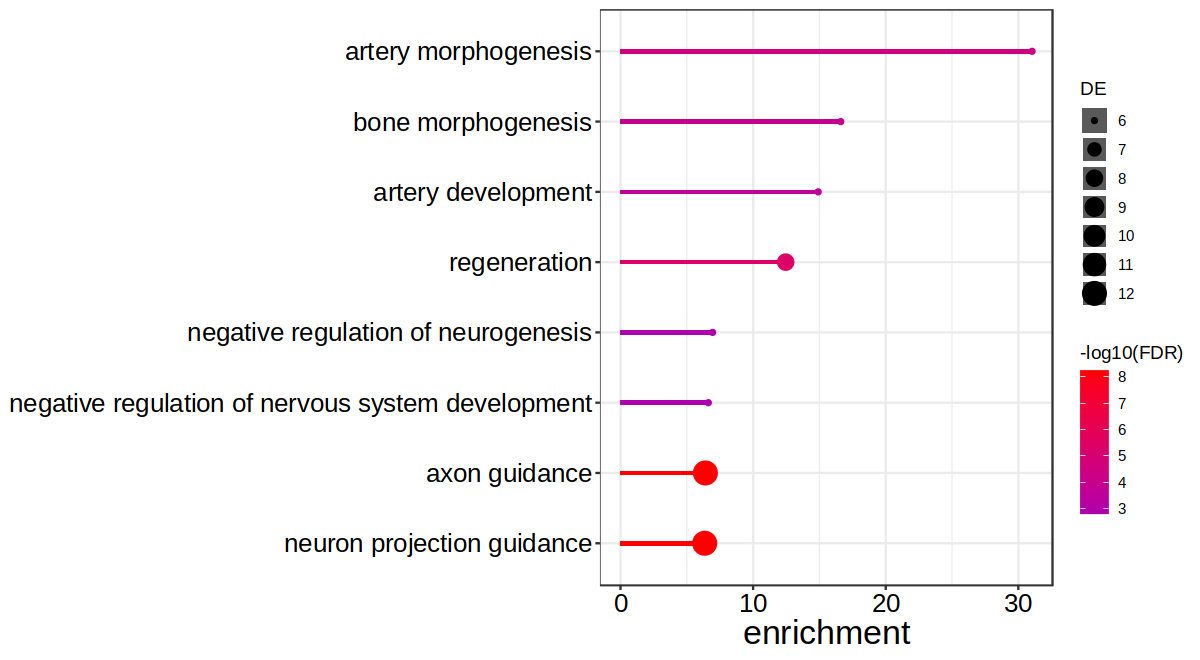

In [301]:
genes = de.results[variable=='Lateral_plate_mesoderm' & sig == TRUE & logFC < 0, gene]

# Retrieve GO
go = as.data.table(goana(mapping[match(genes, external_gene_name),entrezgene_id], species="Mm"), keep.rownames=T) %>% setnames('rn', 'GOALL') %>% 
    .[order(P.DE)] %>%
    .[,FDR := p.adjust(P.DE, method = 'fdr')] %>% 
    .[P.DE < 0.1] %>% 
    .[, enrichment := (length(genes)/N) / (N/32285)] %>%  # 32285 = nrow(rna.sce) # Enrichment should be depending on the number of genes in the term
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)] # set threshold for enrichment at 100
# Add gene names to annotations
GO_genes = AnnotationDbi::select(org.Mm.eg.db, keytype="GOALL", keys=go[, GOALL], columns='ENTREZID') %>% 
    as.data.table() %>% 
    .[, EVIDENCEALL := NULL] %>% 
    unique() %>% 
    merge(., mapping[,c('entrezgene_id', 'external_gene_name')] %>% 
              .[, entrezgene_id := as.character(entrezgene_id)],
          by.x = 'ENTREZID', by.y = 'entrezgene_id')
# Add genes into GO list
go = mclapply(1:nrow(go), function(x){ # nrow(go)
    GO_genes_tmp = GO_genes[GOALL == go[x, GOALL], external_gene_name]
    genes_GO = intersect(GO_genes_tmp, genes)
    tmp = go[x,] %>% .[, `:=`(genes = paste0(genes_GO, collapse = ', '),
                              N = length(intersect(rownames(sce), GO_genes_tmp)))] %>%  # Ntot is only the number of genes in the GO that are also in the SCE object
    .[,enrichment := (DE/N)/(N/32285)] %>% 
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)]
}, mc.cores = 10) %>% rbindlist()

options(repr.plot.width=10, repr.plot.height=5.5)
plot = go %>% copy() %>% 
       .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 50 & N < 1000 & DE > 5 & enrichment > 5] %>% .[order(FDR)] %>% 
        head(20) %>% 
        .[order(-enrichment)] %>% 
        .[,Term := factor(Term, levels = rev(Term))]

ggplot(plot, 
       aes(enrichment, Term, color = -log10(FDR), size = DE)) + 
    geom_bar(stat = 'identity', aes(fill = -log10(FDR)), color = NA,  width = 0.05) +
    geom_point() + 
    scale_color_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    scale_fill_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    xlim(0, max(plot$enrichment)) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_blank())

'select()' returned 1:many mapping between keys and columns



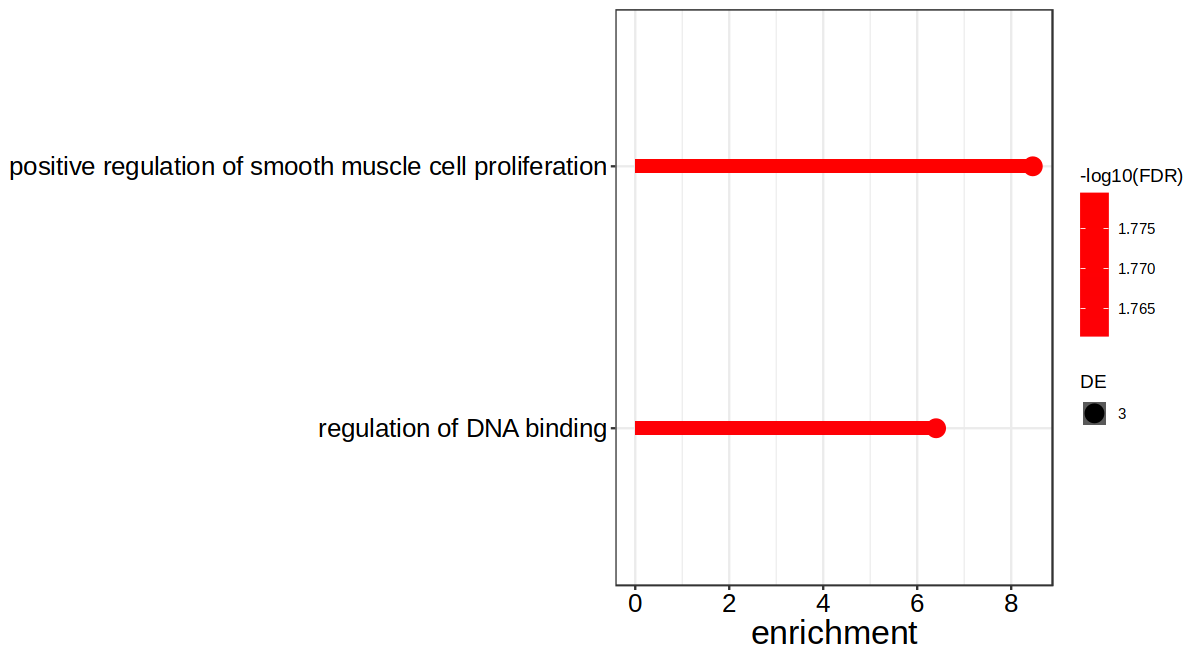

In [316]:
genes = de.results[variable=='Allantois_endothelium' & sig == TRUE & logFC < 0, gene]

# Retrieve GO
go = as.data.table(goana(mapping[match(genes, external_gene_name),entrezgene_id], species="Mm"), keep.rownames=T) %>% setnames('rn', 'GOALL') %>% 
    .[order(P.DE)] %>%
    .[,FDR := p.adjust(P.DE, method = 'fdr')] %>% 
    .[P.DE < 0.1] %>% 
    .[, enrichment := (length(genes)/N) / (N/32285)] %>%  # 32285 = nrow(rna.sce) # Enrichment should be depending on the number of genes in the term
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)] # set threshold for enrichment at 100
# Add gene names to annotations
GO_genes = AnnotationDbi::select(org.Mm.eg.db, keytype="GOALL", keys=go[, GOALL], columns='ENTREZID') %>% 
    as.data.table() %>% 
    .[, EVIDENCEALL := NULL] %>% 
    unique() %>% 
    merge(., mapping[,c('entrezgene_id', 'external_gene_name')] %>% 
              .[, entrezgene_id := as.character(entrezgene_id)],
          by.x = 'ENTREZID', by.y = 'entrezgene_id')
# Add genes into GO list
go = mclapply(1:nrow(go), function(x){ # nrow(go)
    GO_genes_tmp = GO_genes[GOALL == go[x, GOALL], external_gene_name]
    genes_GO = intersect(GO_genes_tmp, genes)
    tmp = go[x,] %>% .[, `:=`(genes = paste0(genes_GO, collapse = ', '),
                              N = length(intersect(rownames(sce), GO_genes_tmp)))] %>%  # Ntot is only the number of genes in the GO that are also in the SCE object
    .[,enrichment := (DE/N)/(N/32285)] %>% 
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)]
}, mc.cores = 10) %>% rbindlist()

options(repr.plot.width=10, repr.plot.height=5.5)
plot = go %>% copy() %>% 
       .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 50 & N < 1000 & enrichment > 5] %>% .[order(FDR)] %>% 
        head(20) %>% 
        .[order(-enrichment)] %>% 
        .[,Term := factor(Term, levels = rev(Term))]

ggplot(plot, 
       aes(enrichment, Term, color = -log10(FDR), size = DE)) + 
    geom_bar(stat = 'identity', aes(fill = -log10(FDR)), color = NA,  width = 0.05) +
    geom_point() + 
    scale_color_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    scale_fill_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    xlim(0, max(plot$enrichment)) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_blank())

'select()' returned 1:many mapping between keys and columns



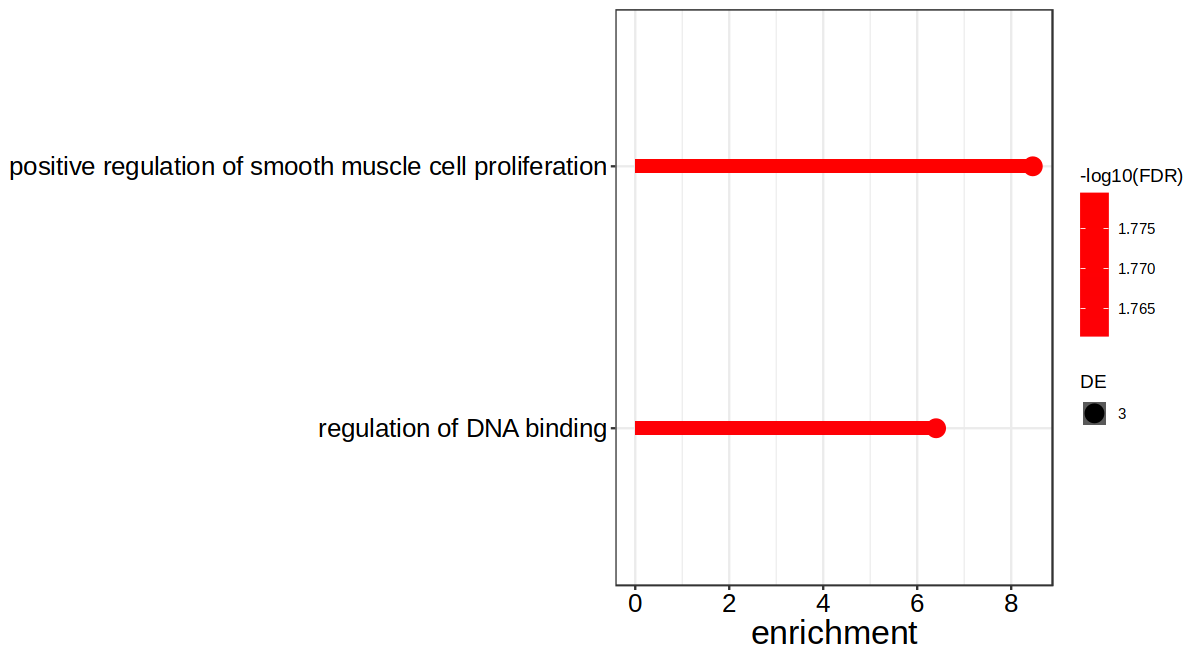

In [317]:
genes = de.results[variable=='Allantois_endothelium' & sig == TRUE & logFC > 0, gene]

# Retrieve GO
go = as.data.table(goana(mapping[match(genes, external_gene_name),entrezgene_id], species="Mm"), keep.rownames=T) %>% setnames('rn', 'GOALL') %>% 
    .[order(P.DE)] %>%
    .[,FDR := p.adjust(P.DE, method = 'fdr')] %>% 
    .[P.DE < 0.1] %>% 
    .[, enrichment := (length(genes)/N) / (N/32285)] %>%  # 32285 = nrow(rna.sce) # Enrichment should be depending on the number of genes in the term
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)] # set threshold for enrichment at 100
# Add gene names to annotations
GO_genes = AnnotationDbi::select(org.Mm.eg.db, keytype="GOALL", keys=go[, GOALL], columns='ENTREZID') %>% 
    as.data.table() %>% 
    .[, EVIDENCEALL := NULL] %>% 
    unique() %>% 
    merge(., mapping[,c('entrezgene_id', 'external_gene_name')] %>% 
              .[, entrezgene_id := as.character(entrezgene_id)],
          by.x = 'ENTREZID', by.y = 'entrezgene_id')
# Add genes into GO list
go = mclapply(1:nrow(go), function(x){ # nrow(go)
    GO_genes_tmp = GO_genes[GOALL == go[x, GOALL], external_gene_name]
    genes_GO = intersect(GO_genes_tmp, genes)
    tmp = go[x,] %>% .[, `:=`(genes = paste0(genes_GO, collapse = ', '),
                              N = length(intersect(rownames(sce), GO_genes_tmp)))] %>%  # Ntot is only the number of genes in the GO that are also in the SCE object
    .[,enrichment := (DE/N)/(N/32285)] %>% 
    .[, enrichment := ifelse(enrichment > 100, 100, enrichment)]
}, mc.cores = 10) %>% rbindlist()

options(repr.plot.width=10, repr.plot.height=5.5)
plot = go %>% copy() %>% 
       .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 50 & N < 1000 & enrichment > 5] %>% .[order(FDR)] %>% 
        head(20) %>% 
        .[order(-enrichment)] %>% 
        .[,Term := factor(Term, levels = rev(Term))]

ggplot(plot, 
       aes(enrichment, Term, color = -log10(FDR), size = DE)) + 
    geom_bar(stat = 'identity', aes(fill = -log10(FDR)), color = NA,  width = 0.05) +
    geom_point() + 
    scale_color_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    scale_fill_gradient2(low = 'blue', mid = 'blue', high = 'red') + 
    xlim(0, max(plot$enrichment)) + 
    theme_bw() + 
    theme(axis.text = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_blank())